In [647]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import calendar
import sqlite3 as sql
import math
import geopandas as gpd
from matplotlib.ticker import MultipleLocator
import pycountry
from wordcloud import WordCloud
import plotly.express as px
from matplotlib.patches import Patch
from matplotlib.colors import Normalize

In [648]:
path = 'netflix_titles.csv'
df = pd.read_csv(path, sep = ',')

display(df.nunique().to_frame().T.set_index(pd.Index(['Valores Únicos'])))
display(df.isnull().sum().to_frame().T.set_index(pd.Index(['Valores Faltantes'])))
display(df[df.duplicated(keep='first', subset='show_id')])

show_id  type  title  director  cast  country  date_added  \
Valores Únicos     8807     2   8807      4528  7692      748        1767   

                release_year  rating  duration  listed_in  description  
Valores Únicos            74      17       220        514         8775

show_id  type  title  director  cast  country  date_added  \
Valores Faltantes        0     0      0      2634   825      831          10   

                   release_year  rating  duration  listed_in  description  
Valores Faltantes             0       4         3          0            0

Empty DataFrame
Columns: [show_id, type, title, director, cast, country, date_added, release_year, rating, duration, listed_in, description]
Index: []

In [649]:
df.head()

show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021          2021  TV-MA   1 Season   
3  September 24, 2021          2021  TV-MA   1 Season   
4  September 24, 2021          2021  TV-MA  2 Seasons   

                                           listed_in  \
0                                      Documentaries   
1    International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Act...   
3                             Docuseries, Reality TV   
4  International TV Shows, Romantic TV Shows, TV ...   

                                         description  
0  As her father nears the end of his life, filmm...  
1  After crossing paths at a party, a Cape Town t...  
2  To protect his family from a powerful drug lor...  
3  Feuds, flirtations and toilet talk go down amo...  
4  In a city of coaching centers known to train I...

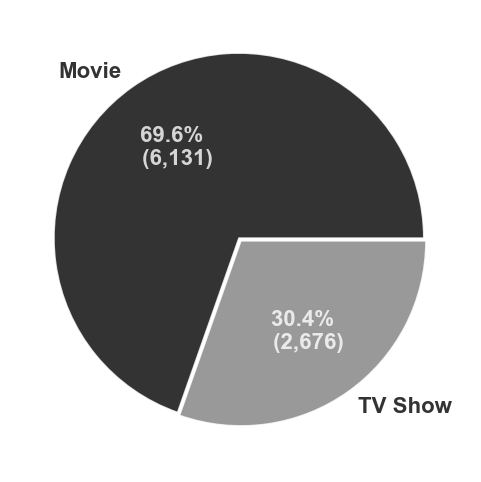

In [650]:
# Pie chart
sns.set_theme()

df.type.value_counts()
fig,ax = plt.subplots(figsize = (6,6))

patches, texts,autotexts = ax.pie (df.type.value_counts(), 
        labels = df.type.value_counts().index, 
        autopct=lambda pct : '{:.1f}% \n ({:,.0f})'.format(pct,pct * sum(df['type'].value_counts())/100),
        textprops= {'color': 'white', 'weight': 'bold', 'size': '16', 'alpha': 0.8},
        colors = ['black', 'gray'], 
        wedgeprops = {'alpha': 0.8}, 
        explode=(.02, 0)
        )

for text in texts:
    text.set_color('black')

In [651]:
# Conversión de parámetros de fecha
df['date_added'] = df['date_added'].fillna(df['date_added'].mode()[0])
df['date_added'] = pd.to_datetime(df['date_added'])
df['month'] = [calendar.month_name[int(date.month)] for date in df['date_added']]
df['year'] = [date.year for date in df['date_added']]
df['month'] = pd.Categorical(df['month'], categories=list(calendar.month_name), ordered=True)

Text(0.5, 1.0, 'Cantidad de títulos agregados a Netflix')

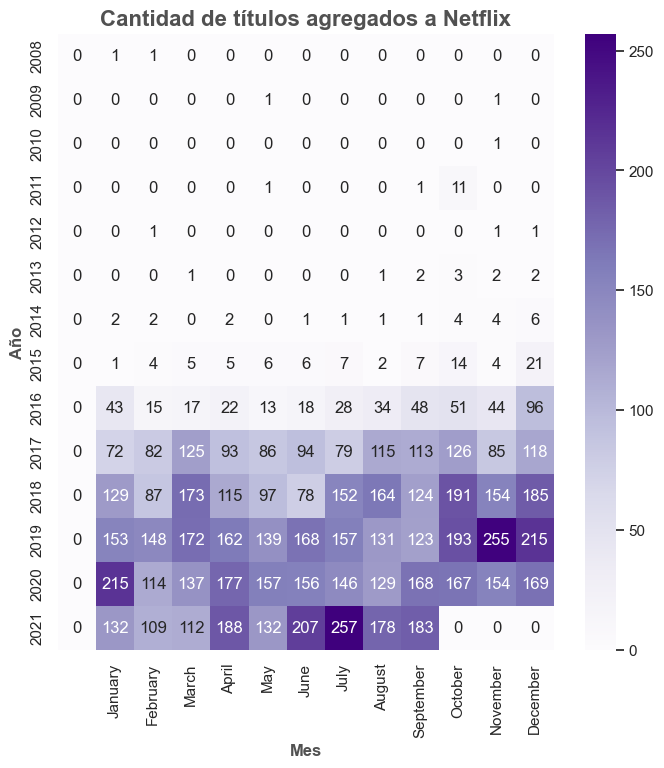

In [652]:
# Títulos agregados por año 
fig,ax = plt.subplots(figsize = (8,8))
pivot_table = pd.pivot_table(df, index='year', columns='month', aggfunc='size', fill_value=0)
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='Purples')

ax.set_xlabel('Mes', fontsize = 12, fontweight = 'bold', alpha = 0.8)
ax.set_ylabel('Año', fontsize = 12, fontweight = 'bold', alpha = 0.8)

ax.set_title('Cantidad de títulos agregados a Netflix', fontsize = 16, fontweight = 'bold', alpha = 0.8)


Text(0.5, 0.975, 'Cantidad de títulos agregados a Netflix')

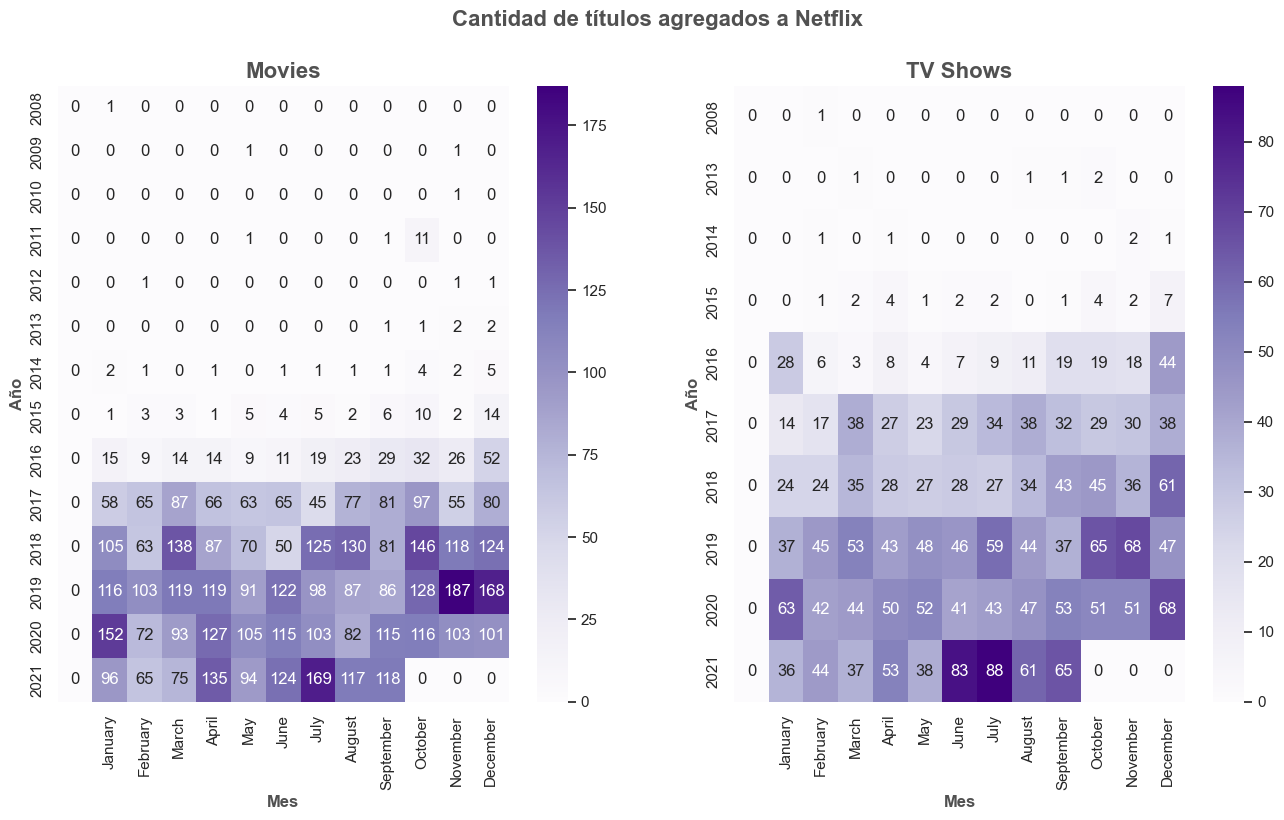

In [653]:
# Títulos agregados por año, discriminados entre TV Shows y Movies
fig,ax = plt.subplots(ncols=2, figsize = (16,8))

pivot_table = pd.pivot_table(df[df['type'] == 'Movie'], index='year', columns='month', aggfunc='size', fill_value=0)
sns.heatmap(pivot_table, ax=ax[0], annot=True, fmt='d', cmap='Purples')

ax[0].set_xlabel('Mes', fontsize = 12, fontweight = 'bold', alpha = 0.8)
ax[0].set_ylabel('Año', fontsize = 12, fontweight = 'bold', alpha = 0.8)

ax[0].set_title('Movies', fontsize = 16, fontweight = 'bold', alpha = 0.8)

pivot_table = pd.pivot_table(df[df['type'] == 'TV Show'], index='year', columns='month', aggfunc='size', fill_value=0)
sns.heatmap(pivot_table, ax=ax[1], annot=True, fmt='d', cmap='Purples')

ax[1].set_xlabel('Mes', fontsize = 12, fontweight = 'bold', alpha = 0.8)
ax[1].set_ylabel('Año', fontsize = 12, fontweight = 'bold', alpha = 0.8)

ax[1].set_title('TV Shows', fontsize = 16, fontweight = 'bold', alpha = 0.8)

fig.suptitle('Cantidad de títulos agregados a Netflix', fontsize = 16, fontweight = 'bold', alpha = 0.8, y = 0.975)


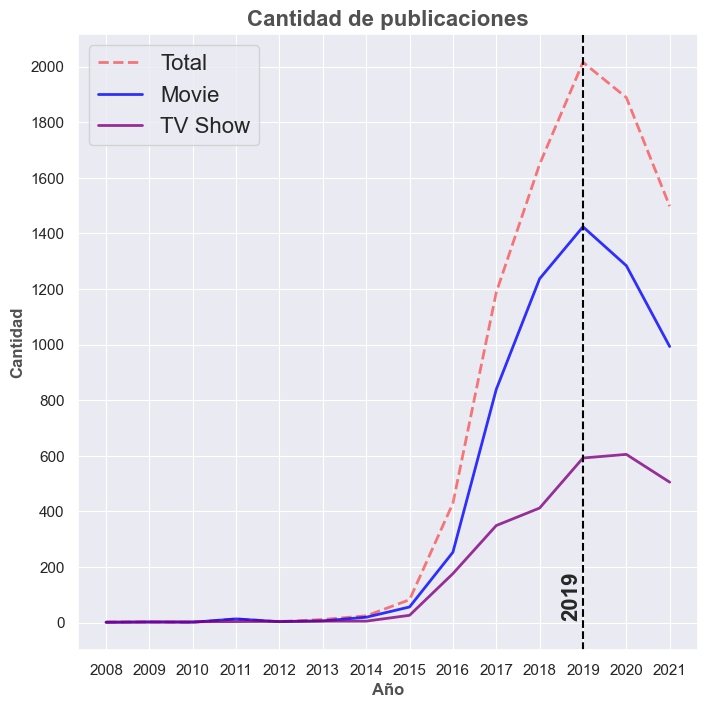

In [654]:
# Cantidad de publicaciones por año
fig,ax = plt.subplots(figsize =(8,8))
colors = ['blue', 'purple']

# Ploteo de totales
x = df['year'].value_counts().index # Años a plotear
y = df['year'].value_counts().values # Cantidad de apariciones de cada año 
sns.lineplot(x = x, y = y, label = 'Total', color = 'red', alpha = 0.5, linewidth = 2, linestyle = 'dashed')

# Ploteo por tipo de publicación
i = 0
for tipo in df['type'].unique():
    df_type = df[df['type'] == tipo]
    x = df_type['year'].value_counts().index
    y = df_type['year'].value_counts().values

    sns.lineplot(x = x, y = y, label = tipo, color = colors[i], alpha = 0.8, linewidth = 2)
    i += 1

# Ploteo de año con más publicaciones
dict_years = dict(df['year'].value_counts())
max_val = df['year'].value_counts().max()

for key,val in dict_years.items():
    if val == max_val:
        max_year = key

ax.axvline(x = max_year, color = 'black', ls = '--', lw = 1.5)
plt.text(x = max_year-0.5, y = 20, s = str(max_year), fontweight = 'bold', rotation = 90, fontsize = 16)

# Ajuste de gráfico
ax.legend(loc = 'upper left', fontsize = 16)
ax.set_xlabel('Año', fontsize = 12, fontweight = 'bold', alpha = 0.8)
ax.set_ylabel('Cantidad', fontsize = 12, fontweight = 'bold', alpha = 0.8)
ax.set_title('Cantidad de publicaciones', fontsize = 16, fontweight = 'bold', alpha = 0.8)
ax.grid(lw = 0.8)
ax.yaxis.set_major_locator(MultipleLocator(200))
ax.xaxis.set_major_locator(MultipleLocator(1))

In [686]:
# Conversión de duración a entero
df['duration_int'] = (df['duration'].apply(lambda x: x.split(' ')[0] if type(x) == str else x)).astype(dtype='int',errors='ignore')
df['duration_int'] = df['duration_int'].apply(lambda x: int(x) if type(x) == str else x)

df.shape

(8807, 15)

In [656]:
# Obtención de géneros y cantidad de apariciones por cada género para el caso de películas
# Dado que hay más de un género por película, se cuenta las veces que aparece 
# cada género individual
genres = {}
for genre in df[df['type'] == 'Movie']['listed_in']:
    for subgenre in genre.split(','):
        subgenre = subgenre.strip()
        if subgenre not in genres:
            genres[subgenre] =1
        else:
            genres[subgenre] += 1

genres

{'Documentaries': 869,
 'Children & Family Movies': 641,
 'Dramas': 2427,
 'Independent Movies': 756,
 'International Movies': 2752,
 'Comedies': 1674,
 'Thrillers': 577,
 'Romantic Movies': 616,
 'Music & Musicals': 375,
 'Horror Movies': 357,
 'Sci-Fi & Fantasy': 243,
 'Action & Adventure': 859,
 'Classic Movies': 116,
 'Anime Features': 71,
 'Sports Movies': 219,
 'Cult Movies': 71,
 'Faith & Spirituality': 65,
 'LGBTQ Movies': 102,
 'Stand-Up Comedy': 343,
 'Movies': 57}

C:\Users\diego\AppData\Local\Temp\ipykernel_4336\2141827668.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\diego\AppData\Local\Temp\ipykernel_4336\2141827668.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\diego\AppData\Local\Temp\ipykernel_4336\2141827668.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

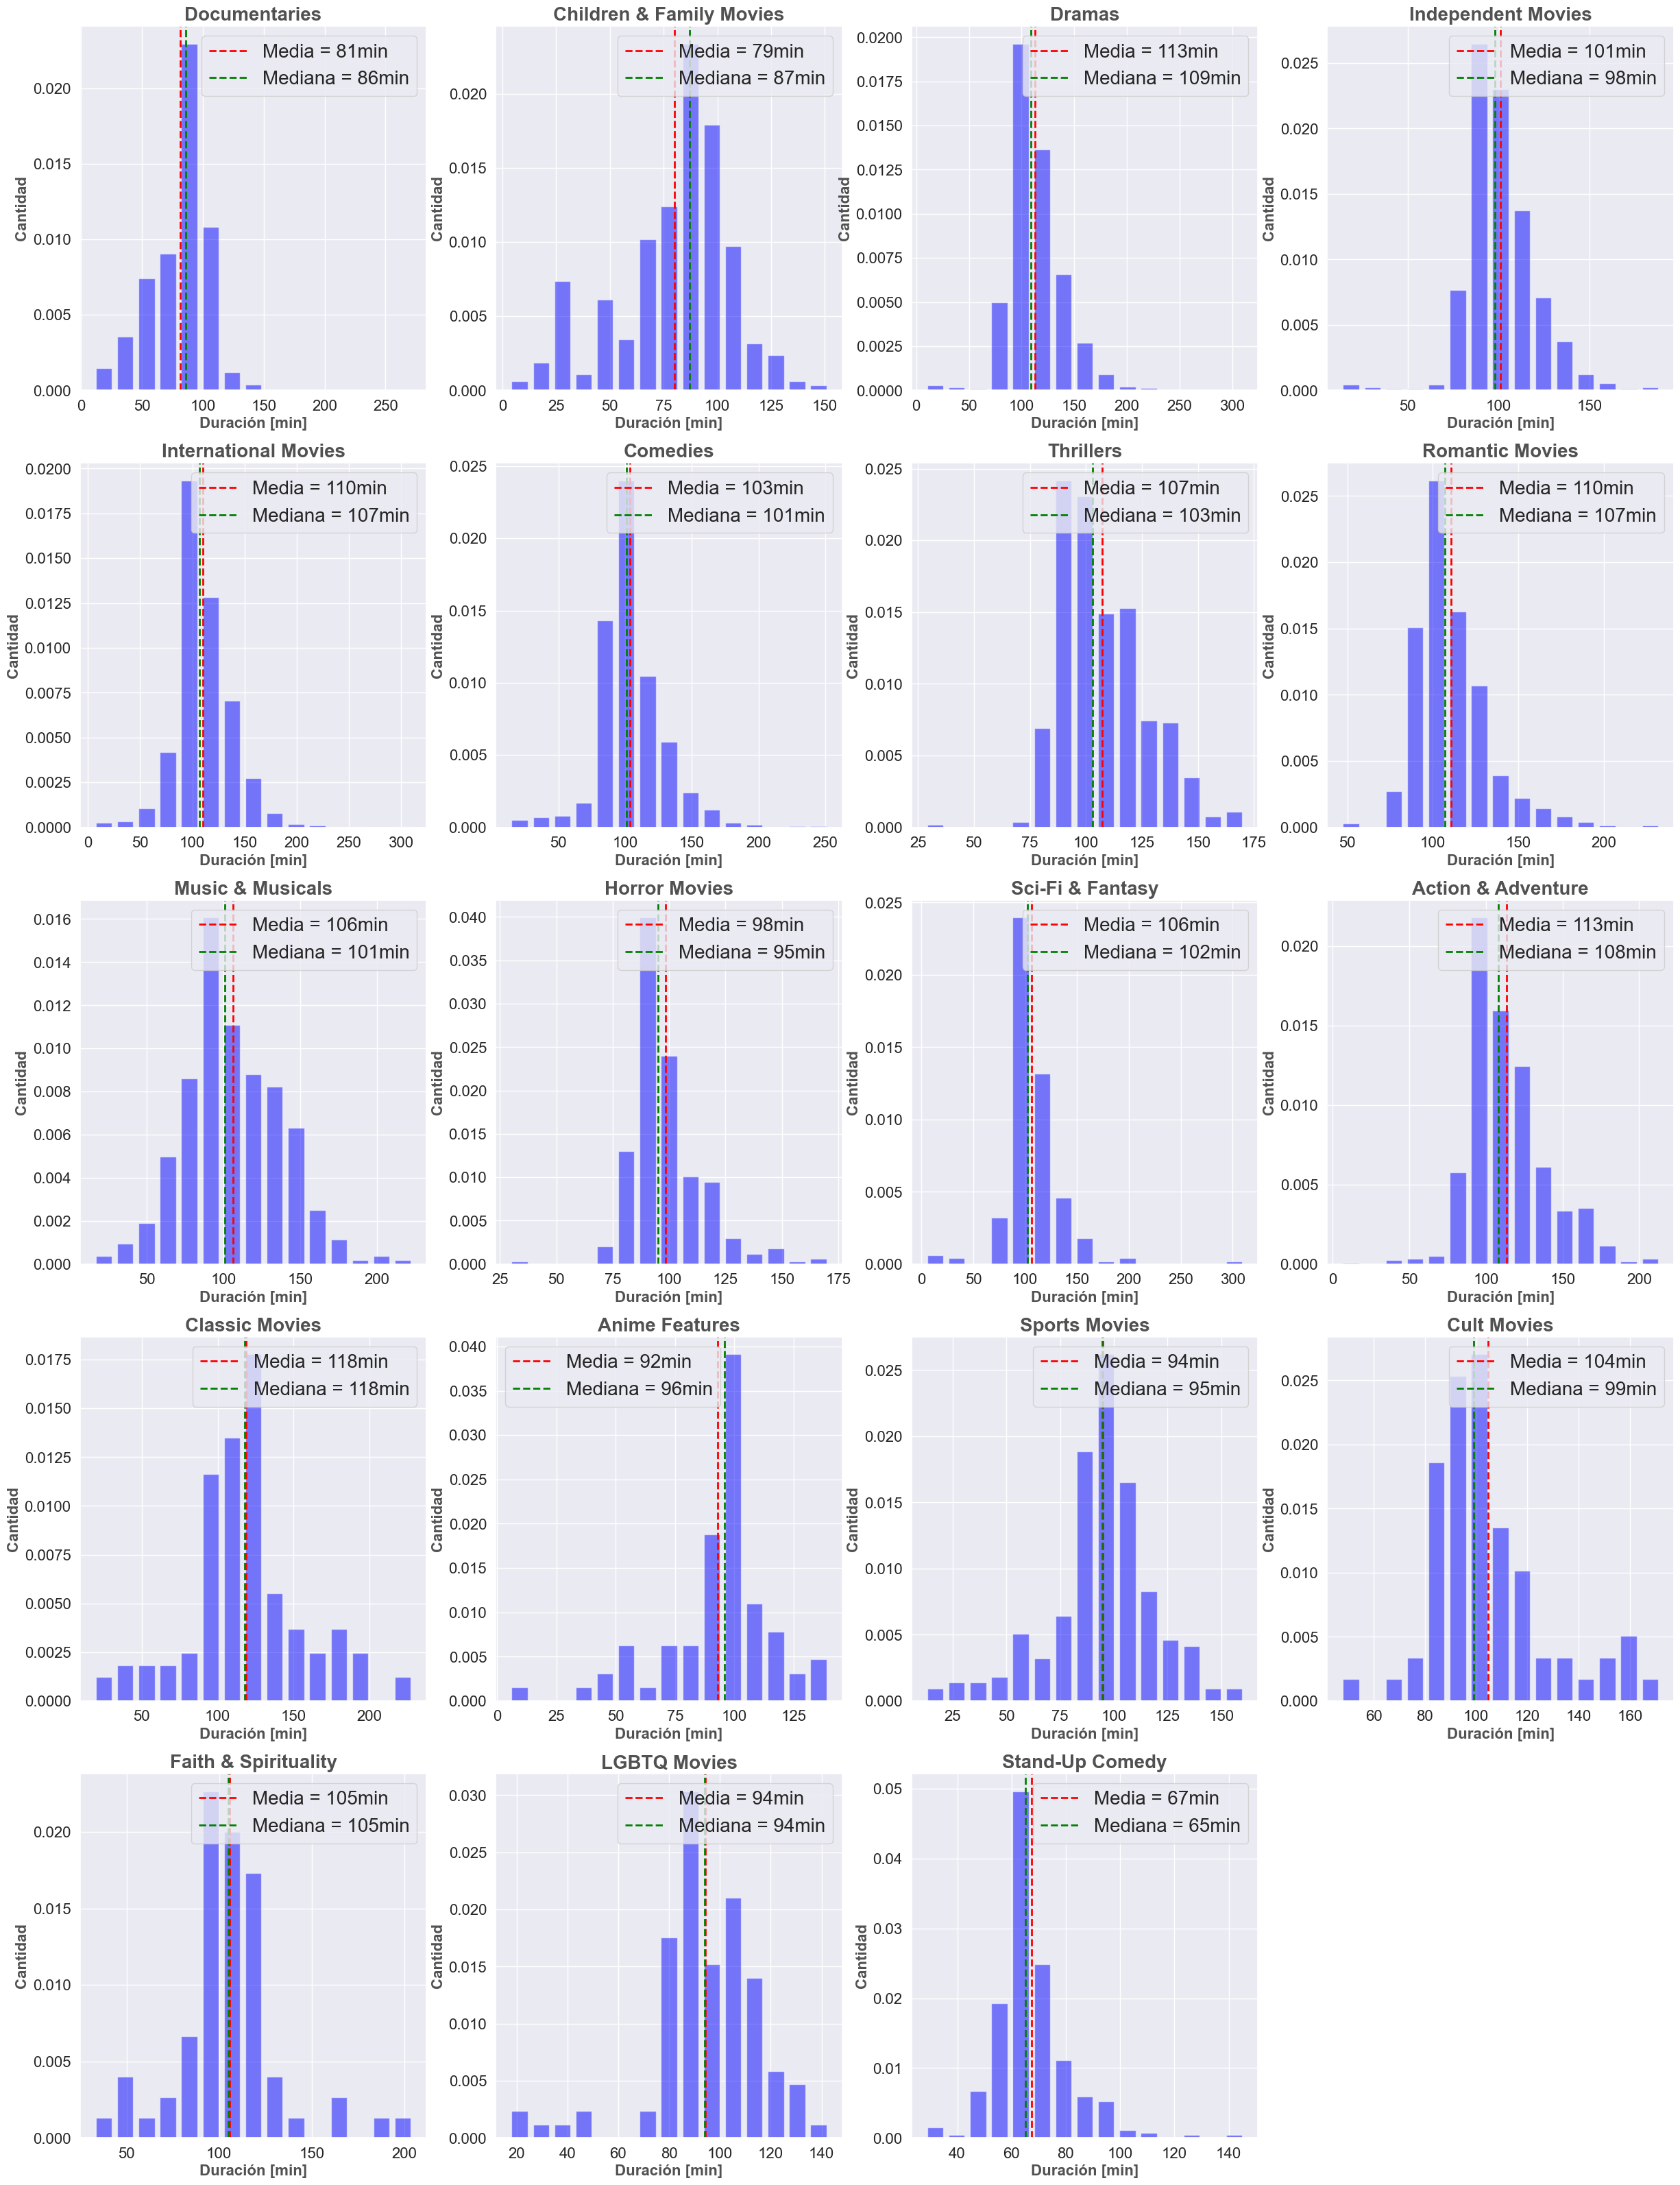

In [657]:
# Histogramas de duración de películas por género
df_titles = list(genres.keys())
df_titles.remove('Movies')
l = len(df_titles)
cols = 4 # max numer of columns
rows = l // cols + 1 if l % cols !=0 else l // cols
fig,ax = plt.subplots(ncols=cols, nrows=rows, figsize = (30,40))
i = 0
for genre in df_titles:
    df_genre = df[(df['listed_in'].str.contains(genre)) & (df['type'] == 'Movie')]
    df_genre['duration_int'] = (df_genre['duration_int']).astype(dtype='int', errors = 'ignore')
    ax.flat[i].hist(x = df_genre['duration_int'], bins = 15, density = True, rwidth = 0.75, alpha = 0.5, color = 'blue')
    ax.flat[i].tick_params(axis = 'y', labelsize = 16)
    ax.flat[i].set_title(df_titles[i], fontsize = 20, fontweight = 'bold', alpha = 0.8)
    ax.flat[i].axvline(x = df_genre['duration_int'].mean(), color = 'red', ls = '--', lw = 2, label = 'Media = ' + str(math.floor(df_genre['duration_int'].mean())) + 'min')
    ax.flat[i].axvline(x = df_genre['duration_int'].median(), color = 'green', ls = '--', lw = 2, label = 'Mediana = ' + str(math.floor(df_genre['duration_int'].median())) + 'min')
    ax.flat[i].set_xlabel('Duración [min]', fontsize = 16, fontweight = 'bold', alpha = 0.8)
    ax.flat[i].set_ylabel('Cantidad', fontsize = 16, fontweight = 'bold', alpha = 0.8)
    ax.flat[i].tick_params(axis = 'both', labelsize = 16)
    ax.flat[i].legend(loc = 'best', fontsize = 20, markerscale = 4)
    i += 1

for ax in ax.flat:
    if not ax.has_data():
        fig.delaxes(ax)

C:\Users\diego\AppData\Local\Temp\ipykernel_4336\1624824857.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



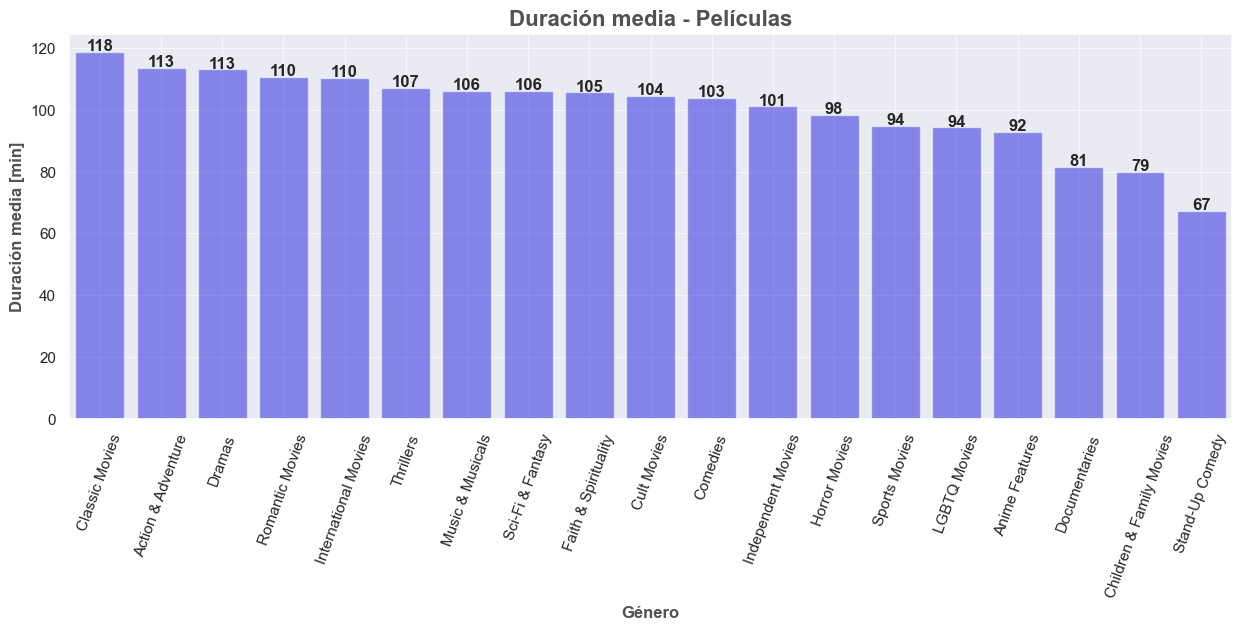

In [658]:
# Ploteo de duraciones medias de películas
medias = {}
for genre in df_titles:
    df_genre = df[(df['listed_in'].str.contains(genre)) & (df['type'] == 'Movie')]
    df_genre['duration_int'] = (df_genre['duration_int']).astype(dtype='int', errors='ignore')
    medias[genre] = df_genre['duration_int'].mean()


df_medias = pd.DataFrame.from_dict(medias, orient='index', columns=['Values']).reset_index()
df_medias = df_medias.rename(columns={'index': 'genre', 'Values': 'media'})

fig,ax = plt.subplots(figsize = (15,5))
sns.barplot(data = df_medias.sort_values(by = 'media', inplace = True, ascending = False), x = df_medias.genre, y = df_medias.media, color = 'blue', alpha = 0.5)
ax.grid(lw = 0.5)

for i in range(l):
    plt.text(x=i, y=df_medias.iloc[i]['media'] + 0.40, s=str(math.floor(df_medias.iloc[i]['media'])), ha='center', fontweight = 'bold')

ax.set_xlabel ('Género', fontsize = 12, fontweight = 'bold', alpha = 0.8)
ax.set_ylabel ('Duración media [min]', fontsize = 12, fontweight = 'bold', alpha = 0.8)
ax.set_title ('Duración media - Películas', fontsize = 16, fontweight = 'bold', alpha = 0.8)
ax.tick_params (axis='x', rotation = 70)

In [659]:
# Obtención de géneros y cantidad de apariciones por cada género para el caso de series
# Dado que hay más de un género por película, se cuenta las veces que aparece 
# cada género individual
genres_shows = {}
for genre in df[df['type'] == 'TV Show']['listed_in']:
    for subgenre in genre.split(','):
        subgenre = subgenre.strip()
        if subgenre not in genres_shows:
            genres_shows[subgenre] =1
        else:
            genres_shows[subgenre] += 1

genres_shows

{'International TV Shows': 1351,
 'TV Dramas': 763,
 'TV Mysteries': 98,
 'Crime TV Shows': 470,
 'TV Action & Adventure': 168,
 'Docuseries': 395,
 'Reality TV': 255,
 'Romantic TV Shows': 370,
 'TV Comedies': 581,
 'TV Horror': 75,
 'British TV Shows': 253,
 'Spanish-Language TV Shows': 174,
 'TV Thrillers': 57,
 "Kids' TV": 451,
 'TV Sci-Fi & Fantasy': 84,
 'Anime Series': 176,
 'Korean TV Shows': 151,
 'Science & Nature TV': 92,
 'Teen TV Shows': 69,
 'TV Shows': 16,
 'Stand-Up Comedy & Talk Shows': 56,
 'Classic & Cult TV': 28}

C:\Users\diego\AppData\Local\Temp\ipykernel_4336\1706797348.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\diego\AppData\Local\Temp\ipykernel_4336\1706797348.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\diego\AppData\Local\Temp\ipykernel_4336\1706797348.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

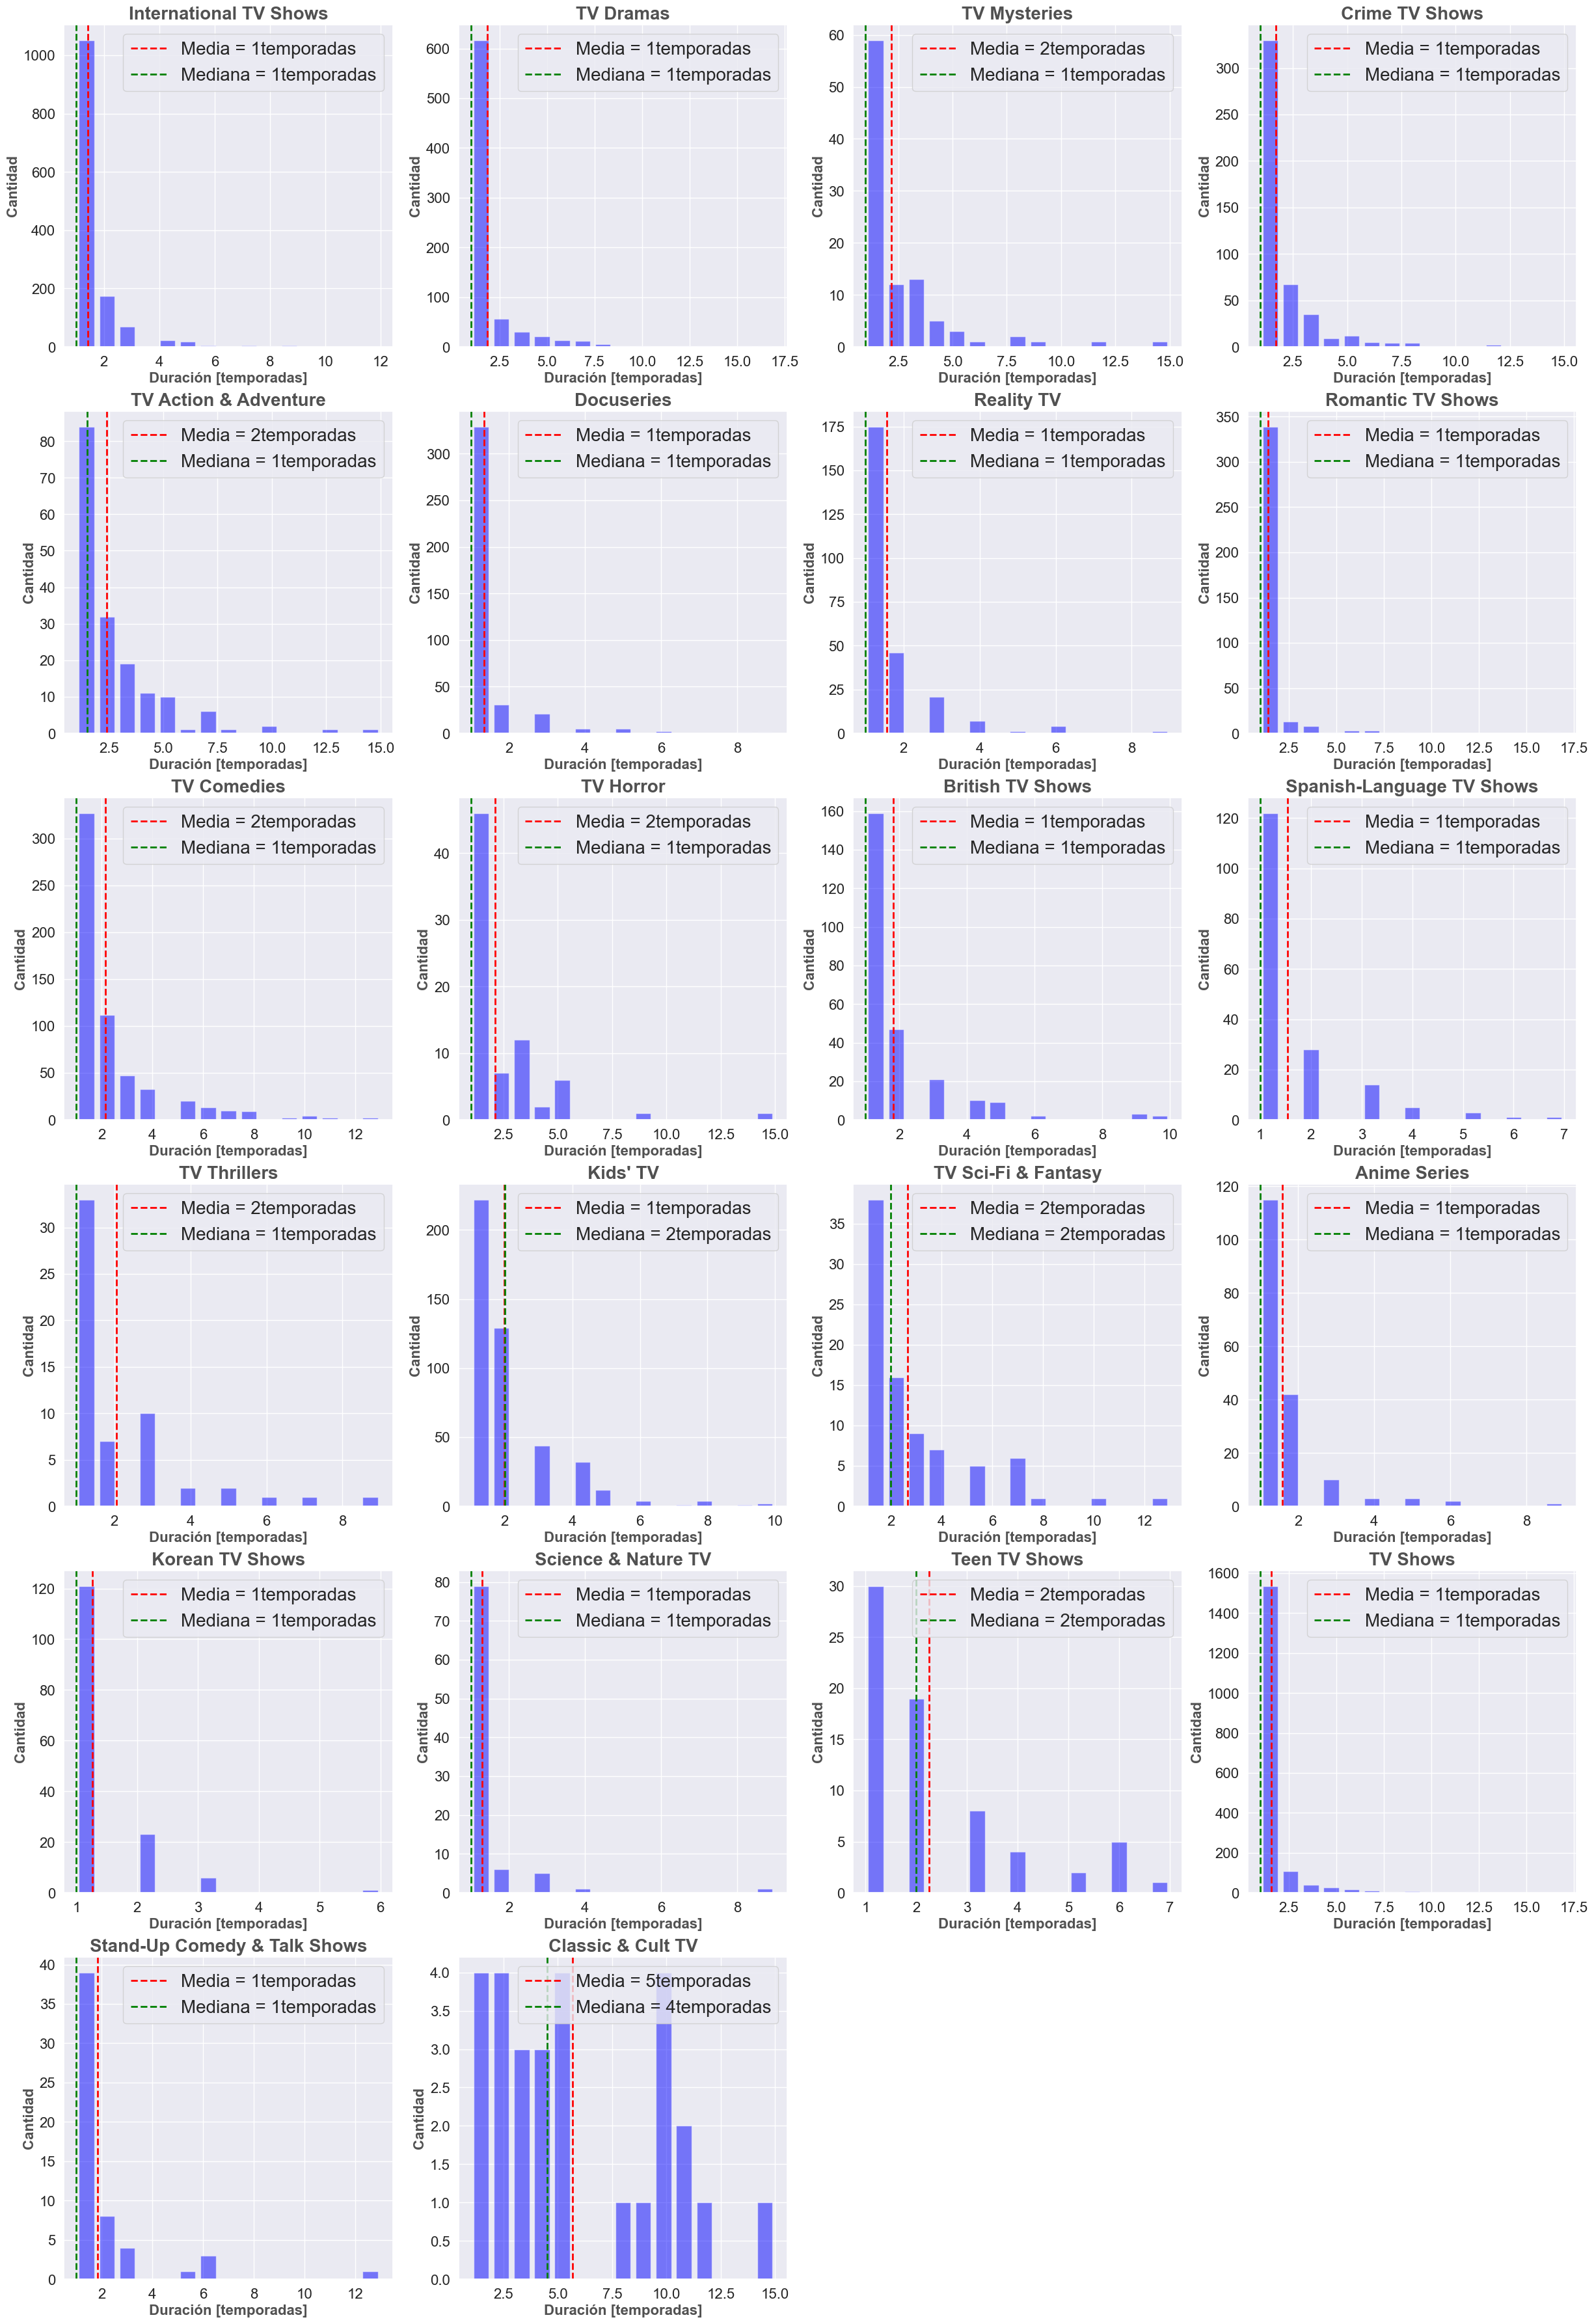

In [660]:
# Histogramas de duración de series por género
df_titles = list(genres_shows.keys())
l = len(df_titles)
cols = 4 # max numer of columns
rows = l // cols + 1 if l % cols !=0 else l // cols
fig,ax = plt.subplots(ncols=cols, nrows=rows, figsize = (30,45))
i = 0
for genre in df_titles:
    df_genre = df[(df['listed_in'].str.contains(genre)) & (df['type'] == 'TV Show')]
    df_genre['duration_int'] = (df_genre['duration_int']).astype(dtype='int', errors = 'ignore')
    ax.flat[i].hist(x = df_genre['duration_int'], bins = 15, density = False, rwidth = 0.75, alpha = 0.5, color = 'blue')
    ax.flat[i].tick_params(axis = 'y', labelsize = 16)
    ax.flat[i].set_title(df_titles[i], fontsize = 20, fontweight = 'bold', alpha = 0.8)
    ax.flat[i].axvline(x = df_genre['duration_int'].mean(), color = 'red', ls = '--', lw = 2, label = 'Media = ' + str(math.floor(df_genre['duration_int'].mean())) + 'temporadas')
    ax.flat[i].axvline(x = df_genre['duration_int'].median(), color = 'green', ls = '--', lw = 2, label = 'Mediana = ' + str(math.floor(df_genre['duration_int'].median())) + 'temporadas')
    ax.flat[i].set_xlabel('Duración [temporadas]', fontsize = 16, fontweight = 'bold', alpha = 0.8)
    ax.flat[i].set_ylabel('Cantidad', fontsize = 16, fontweight = 'bold', alpha = 0.8)
    ax.flat[i].tick_params(axis = 'both', labelsize = 16)
    ax.flat[i].legend(loc = 'best', fontsize = 20, markerscale = 4)
    i += 1

for ax in ax.flat:
    if not ax.has_data():
        fig.delaxes(ax)

C:\Users\diego\AppData\Local\Temp\ipykernel_4336\2690113181.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



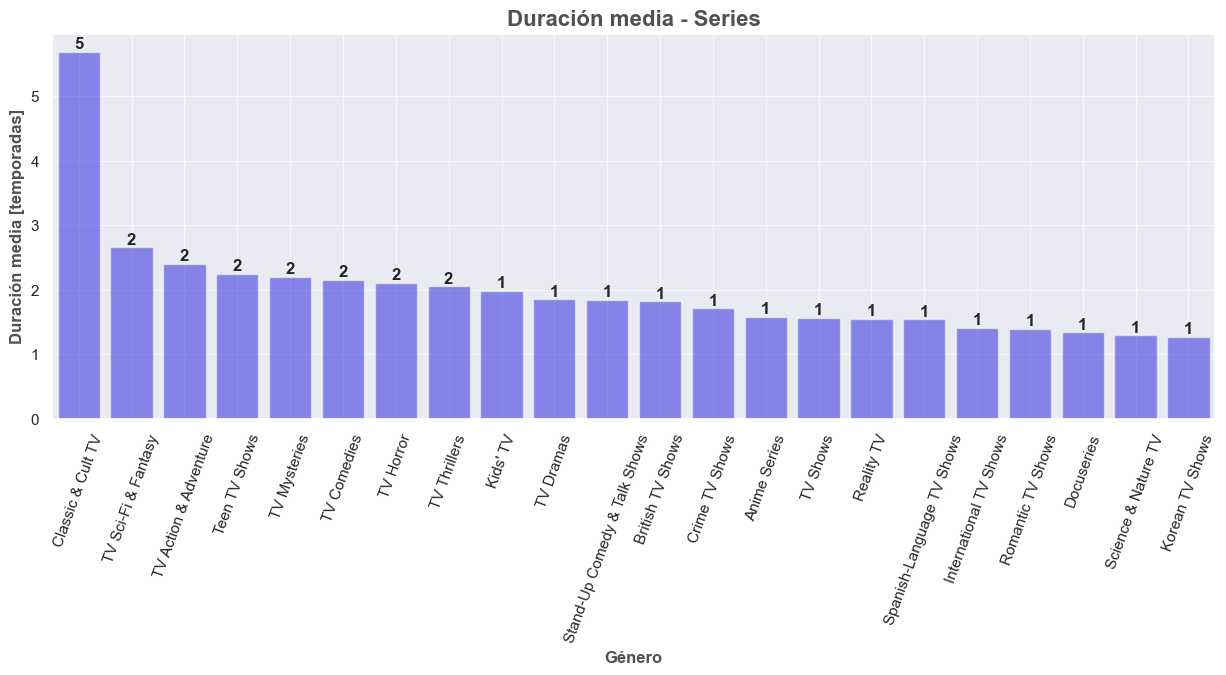

In [661]:
# Ploteo de duraciones medias de series
medias = {}
for genre in df_titles:
    df_genre = df[(df['listed_in'].str.contains(genre)) & (df['type'] == 'TV Show')]
    df_genre['duration_int'] = (df_genre['duration_int']).astype(dtype='int', errors='ignore')
    medias[genre] = df_genre['duration_int'].mean()


df_medias = pd.DataFrame.from_dict(medias, orient='index', columns=['Values']).reset_index()
df_medias = df_medias.rename(columns={'index': 'genre', 'Values': 'media'})

fig,ax = plt.subplots(figsize = (15,5))
sns.barplot(data = df_medias.sort_values(by = 'media', inplace = True, ascending = False), x = df_medias.genre, y = df_medias.media, color = 'blue', alpha = 0.5)
ax.grid(lw = 0.5)

for i in range(l):
    plt.text(x=i, y=df_medias.iloc[i]['media'] + 0.05, s=str(math.floor(df_medias.iloc[i]['media'])), ha='center', fontweight = 'bold')

ax.set_xlabel ('Género', fontsize = 12, fontweight = 'bold', alpha = 0.8)
ax.set_ylabel ('Duración media [temporadas]', fontsize = 12, fontweight = 'bold', alpha = 0.8)
ax.set_title ('Duración media - Series', fontsize = 16, fontweight = 'bold', alpha = 0.8)
ax.tick_params (axis='x', rotation = 70)

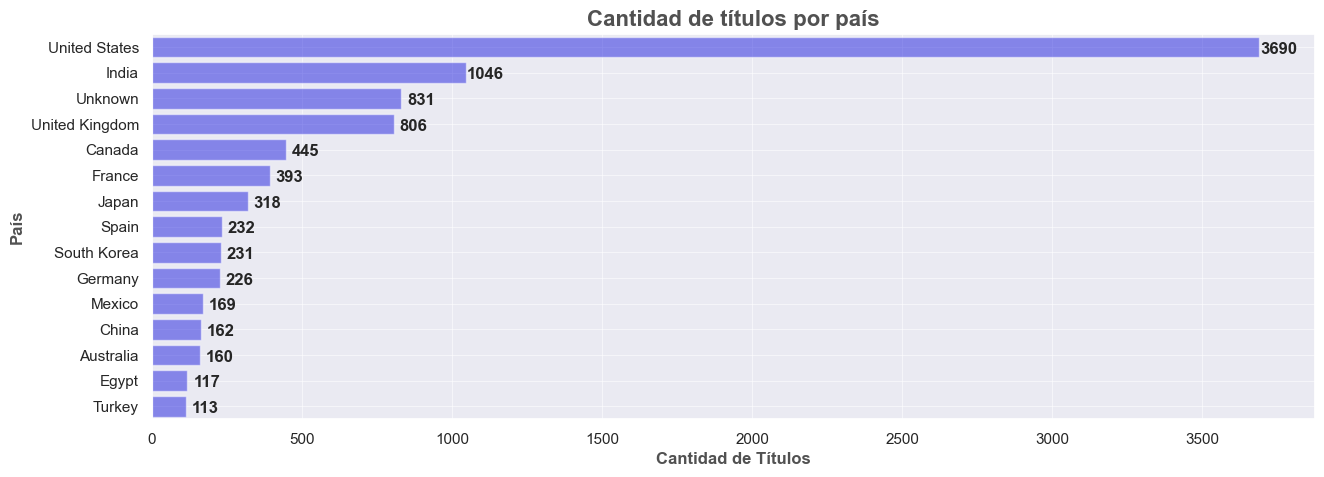

In [666]:
# Cantidad de títulos por país
countries = {}
df['country'] = df['country'].fillna('Unknown')
for country in df['country']:
    for i in country.split(','):
        i = i.strip()
        if i not in countries:
            countries[i] =1
        else:
            countries[i] += 1

df_countries = pd.DataFrame(list(countries.items()), columns=['Country', 'Count'])

df_countries = df_countries.sort_values(by='Count', ascending=False).head(15)

fig,ax = plt.subplots(figsize = (15,5))
sns.barplot(data = df_countries, x = 'Count', y = 'Country', color = 'blue', alpha = 0.5, orient='horizontal')
ax.grid(lw = 0.5)

for i in range(len(df_countries)):
    plt.text(y=i+0.25, x=df_countries['Count'].iloc[i] + 65, s=str(df_countries['Count'].iloc[i]), ha='center', fontweight = 'bold')

ax.set_xlabel ('Cantidad de Títulos', fontsize = 12, fontweight = 'bold', alpha = 0.8)
ax.set_ylabel ('País', fontsize = 12, fontweight = 'bold', alpha = 0.8)
ax.set_title ('Cantidad de títulos por país', fontsize = 16, fontweight = 'bold', alpha = 0.8)
ax.grid(lw = 0.4)

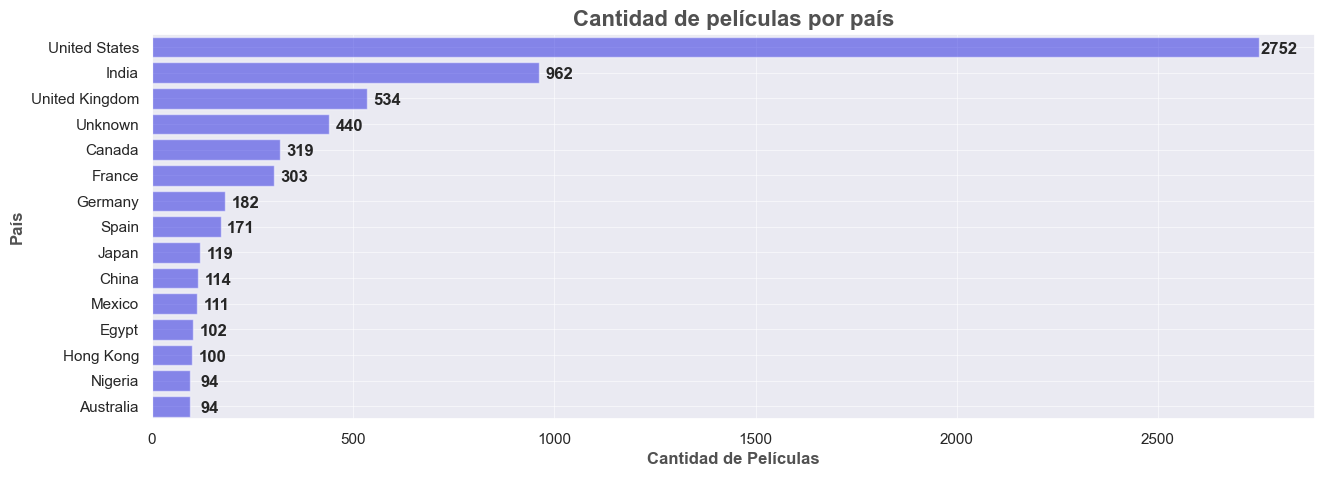

In [667]:
# Cantidad de películas por país
countries = {}
for country in df[df['type'] == 'Movie']['country']:
    for i in country.split(','):
        i = i.strip()
        if i not in countries:
            countries[i] =1
        else:
            countries[i] += 1

df_countries = pd.DataFrame(list(countries.items()), columns=['Country', 'Count'])

df_countries = df_countries.sort_values(by='Count', ascending=False).head(15)

fig,ax = plt.subplots(figsize = (15,5))
sns.barplot(data = df_countries, x = 'Count', y = 'Country', color = 'blue', alpha = 0.5, orient='horizontal')
ax.grid(lw = 0.5)

for i in range(len(df_countries)):
    plt.text(y=i+0.25, x=df_countries['Count'].iloc[i] + 50, s=str(df_countries['Count'].iloc[i]), ha='center', fontweight = 'bold')

ax.set_xlabel ('Cantidad de Películas', fontsize = 12, fontweight = 'bold', alpha = 0.8)
ax.set_ylabel ('País', fontsize = 12, fontweight = 'bold', alpha = 0.8)
ax.set_title ('Cantidad de películas por país', fontsize = 16, fontweight = 'bold', alpha = 0.8)
ax.grid(lw = 0.4)

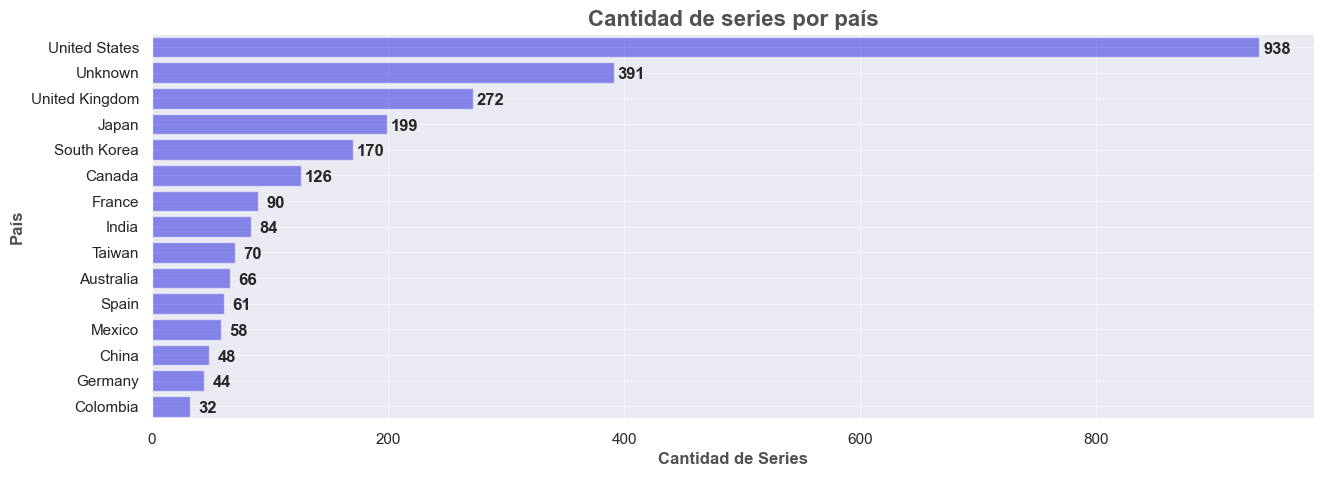

In [668]:
# Cantidad de series por país
countries = {}
for country in df[df['type'] == 'TV Show']['country']:
    for i in country.split(','):
        i = i.strip()
        if i not in countries:
            countries[i] =1
        else:
            countries[i] += 1

df_countries = pd.DataFrame(list(countries.items()), columns=['Country', 'Count'])

df_countries = df_countries.sort_values(by='Count', ascending=False).head(15)

fig,ax = plt.subplots(figsize = (15,5))
sns.barplot(data = df_countries, x = 'Count', y = 'Country', color = 'blue', alpha = 0.5, orient='horizontal')
ax.grid(lw = 0.5)

for i in range(len(df_countries)):
    plt.text(y=i+0.25, x=df_countries['Count'].iloc[i] + 15, s=str(df_countries['Count'].iloc[i]), ha='center', fontweight = 'bold')

ax.set_xlabel ('Cantidad de Series', fontsize = 12, fontweight = 'bold', alpha = 0.8)
ax.set_ylabel ('País', fontsize = 12, fontweight = 'bold', alpha = 0.8)
ax.set_title ('Cantidad de series por país', fontsize = 16, fontweight = 'bold', alpha = 0.8)
ax.grid(lw = 0.4)

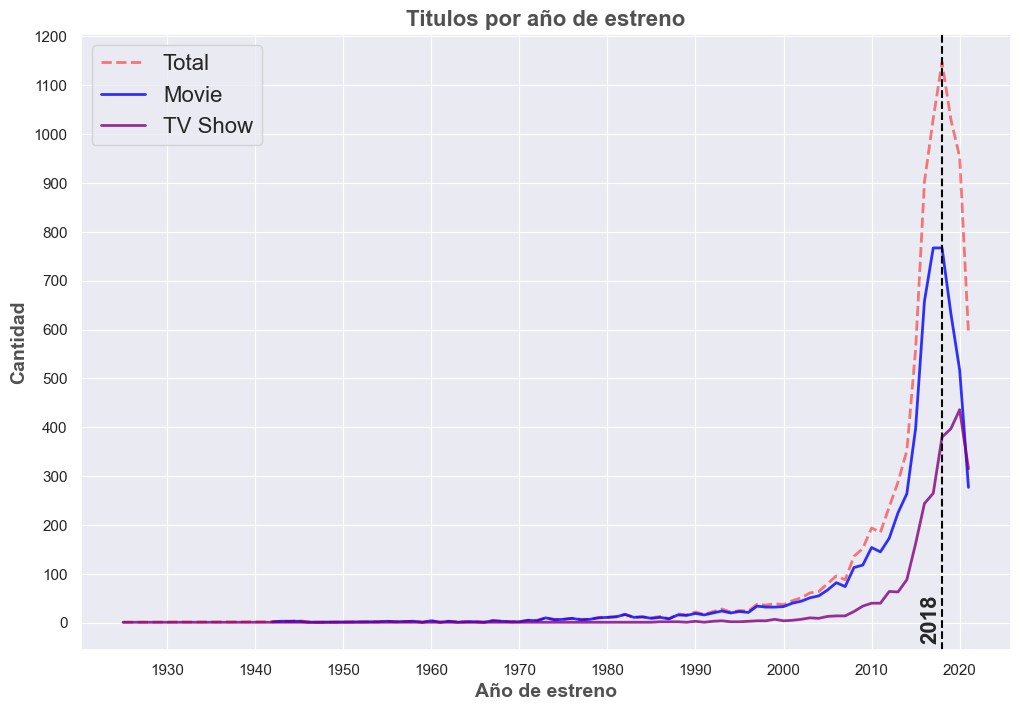

In [669]:
# Cantidad de estrenos por año
fig,ax = plt.subplots(figsize =(12,8))
colors = ['blue', 'purple']

# Ploteo de totales
x = df['release_year'].value_counts().index
y = df['release_year'].value_counts().values
sns.lineplot(x = x, y = y, label = 'Total', color = 'red', alpha = 0.5, linewidth = 2, linestyle = 'dashed')

# Ploteo discriminado por tipo
i = 0
for tipo in df['type'].unique():
    df_type = df[df['type'] == tipo]
    x = df_type['release_year'].value_counts().index
    y = df_type['release_year'].value_counts().values

    sns.lineplot(x = x, y = y, label = tipo, color = colors[i], alpha = 0.8, linewidth = 2)
    i += 1

# Ploteo de año con mayor cantidad de estrenos
dict_years = dict(df['release_year'].value_counts())
max_val = df['release_year'].value_counts().max()

for key,val in dict_years.items():
    if val == max_val:
        max_year = key

ax.axvline(x = max_year, color = 'black', ls = '--', lw = 1.5, )
plt.text(x = max_year-2.5, y = -35, s = str(max_year), fontweight = 'bold', rotation = 90, fontsize = 16)


# Ajuste de gráfico
ax.legend(loc = 'upper left', fontsize = 16)
ax.set_xlabel('Año de estreno', fontsize = 14, fontweight = 'bold', alpha = 0.8)
ax.set_ylabel('Cantidad', fontsize = 14, fontweight = 'bold', alpha = 0.8)
ax.set_title('Titulos por año de estreno', fontsize = 16, fontweight = 'bold', alpha = 0.8)
ax.grid(lw = 0.8)
ax.yaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_major_locator(MultipleLocator(10))

In [670]:
# Generación de dataframes auxiliares para visualizaciones
df['country'] = df['country'].fillna('Unknown')

totals = {}
movies = {}
shows = {}

for country in df['country']:
    countries = [string.strip() for string in country.split(',')]
    for i in countries:
        if i not in totals:
            totals[i] = 1  
        else: 
            totals[i] += 1

for country in df[df['type'] == 'Movie']['country']:
    countries = [string.strip() for string in country.split(',')]
    for i in countries:
        if i not in movies:
            movies[i] = 1  
        else: 
            movies[i] += 1      

for country in df[df['type'] == 'TV Show']['country']:
    countries = [string.strip() for string in country.split(',')]
    for i in countries:
        if i not in shows:
            shows[i] = 1  
        else: 
            shows[i] += 1


for country in totals:
    if country not in movies:
        movies[country] = 0

for country in totals:
    if country not in shows:
        shows[country] = 0        

In [671]:
countries = pd.DataFrame(totals.items(), columns=['country', 'total'])

countries['movies'] = [movies[country] for country in countries['country']]
countries['shows'] = [shows[country] for country in countries['country']]

# Function to get ISO alpha-3 country code from a country name
def get_country_code(country_name):
    try:
        country = pycountry.countries.get(name=country_name)
        if country:
            return country.alpha_3
    except AttributeError:
        pass
    return None

# Add column with country code
countries['code'] = countries['country'].apply(get_country_code)

# Drop Unknown values
index = (countries[countries['country'] == 'Unknown']).index
countries = countries.drop(index)

countries


country  total  movies  shows  code
0    United States   3690    2752    938   USA
1     South Africa     62      51     11   ZAF
3            India   1046     962     84   IND
4            Ghana      5       5      0   GHA
5     Burkina Faso      1       1      0   BFA
..             ...    ...     ...    ...   ...
119          Sudan      1       1      0   SDN
120         Panama      1       1      0   PAN
121         Uganda      1       1      0   UGA
122   East Germany      1       1      0  None
123     Montenegro      1       1      0   MNE

[123 rows x 5 columns]

In [672]:
# Agrego columna de text para mostra en mapa
countries['text'] = countries.apply(lambda row: f"{row['country']}<br>Total: {str(row['total'])}<br>Movies: {str(row['movies'])}<br>TV Shows: {str(row['shows'])}", axis = 1)

In [673]:
# Create an interactive map plot using Plotly Express
fig = px.scatter_geo(
    countries,
    color = None,
    locations='code',
    size='total',
    hover_name='text',
    hover_data = None,
    text = None,
    locationmode="ISO-3",
    projection="equirectangular",
    title="<br> Number of Titles Produced by Country </br>",
    )

# Customize the layout
fig.update_geos(showcountries=True, countrycolor="snow", scope = 'world', coastlinewidth = 2, landcolor = '#9ba7af',  bgcolor = 'snow', coastlinecolor = 'snow')
fig.update_layout(geo=dict(showframe=False, showcoastlines=True, projection_scale=1), 
    width = 1500,
    height = 800,
    margin=dict(l=0, r=0, t=0, b=0),
    title=dict(
        text="Cantidad de títulos por país",  # Update the title text
        x=0.5,  # Set the title's x position to center
        font=dict(size=30, color="black", family="Calibri"),  # Update font settings
        yanchor="top",  # Anchor the title's vertical position to the top
        y=1
      ))  # Set the title's y position)


selected_countries = ['USA', 'GBR']  # List of selected countries
size_factor = 5  # Scale factor for the selected markers

# Scale the size of selected markers
countries.loc[countries['code'].isin(selected_countries), 'total'] *= size_factor

fig.update_traces(marker=dict(color="black"))
# Show the interactive map plot
fig.show()

In [674]:
# Conteo apariciones de cada género para películas
genres_movies = {}
for genre in df[df['type'] == 'Movie']['listed_in']:
    for subgenre in genre.split(','):
        subgenre = subgenre.strip()
        if subgenre not in genres_movies:
            genres_movies[subgenre] =1
        else:
            genres_movies[subgenre] += 1

# Conteo apariciones de cada género para series
genres_shows = {}
for genre in df[df['type'] == 'TV Show']['listed_in']:
    for subgenre in genre.split(','):
        subgenre = subgenre.strip()
        if subgenre not in genres_shows:
            genres_shows[subgenre] =1
        else:
            genres_shows[subgenre] += 1

# Conteo apariciones de cada género para títulos totales
genres = {}
for genre in df['listed_in']:
    for subgenre in genre.split(','):
        subgenre = subgenre.strip()
        if subgenre not in genres:
            genres[subgenre] =1
        else:
            genres[subgenre] += 1

# Dataframes con géneros y cantidad de apariciones
df_genre_movies = pd.DataFrame({'genre': genres_movies.keys(), 'appearances': genres_movies.values()})
df_genre_shows = pd.DataFrame({'genre': genres_shows.keys(), 'appearances': genres_shows.values()})
df_genre = pd.DataFrame({'genre': genres.keys(), 'appearances': genres.values()})

In [675]:
# Rating mas comun para cada genero 
ratings_movies = {}
ratings_shows = {}
ratings_totals = {}

for genre in df_genre_movies['genre']:
    df_g_movie = df.loc[(df['listed_in'].str.contains(genre)) & (df['type'] == 'Movie')]
    rating_movie = df_g_movie['rating'].mode()[0]
    ratings_movies[genre] = rating_movie

for genre in df_genre_shows['genre']:
    df_g_show = df.loc[(df['listed_in'].str.contains(genre)) & (df['type'] == 'TV Show')]
    rating_show = df_g_show['rating'].mode()[0]
    ratings_shows[genre] = rating_show

for genre in df_genre['genre']:
    df_g_total = df.loc[df['listed_in'].str.contains(genre)]
    rating_total = df_g_total['rating'].mode()[0]
    ratings_totals[genre] = rating_total

In [676]:
# Adición de columna de rating más frecuente a dataframes
df_genre_movies['rating'] = [ratings_movies[genre] for genre in df_genre_movies['genre']]
df_genre_shows['rating'] = [ratings_shows[genre] for genre in df_genre_shows['genre']]
df_genre['rating'] = [ratings_totals[genre] for genre in df_genre['genre']]

(0.0, 1.0, 0.0, 1.0)

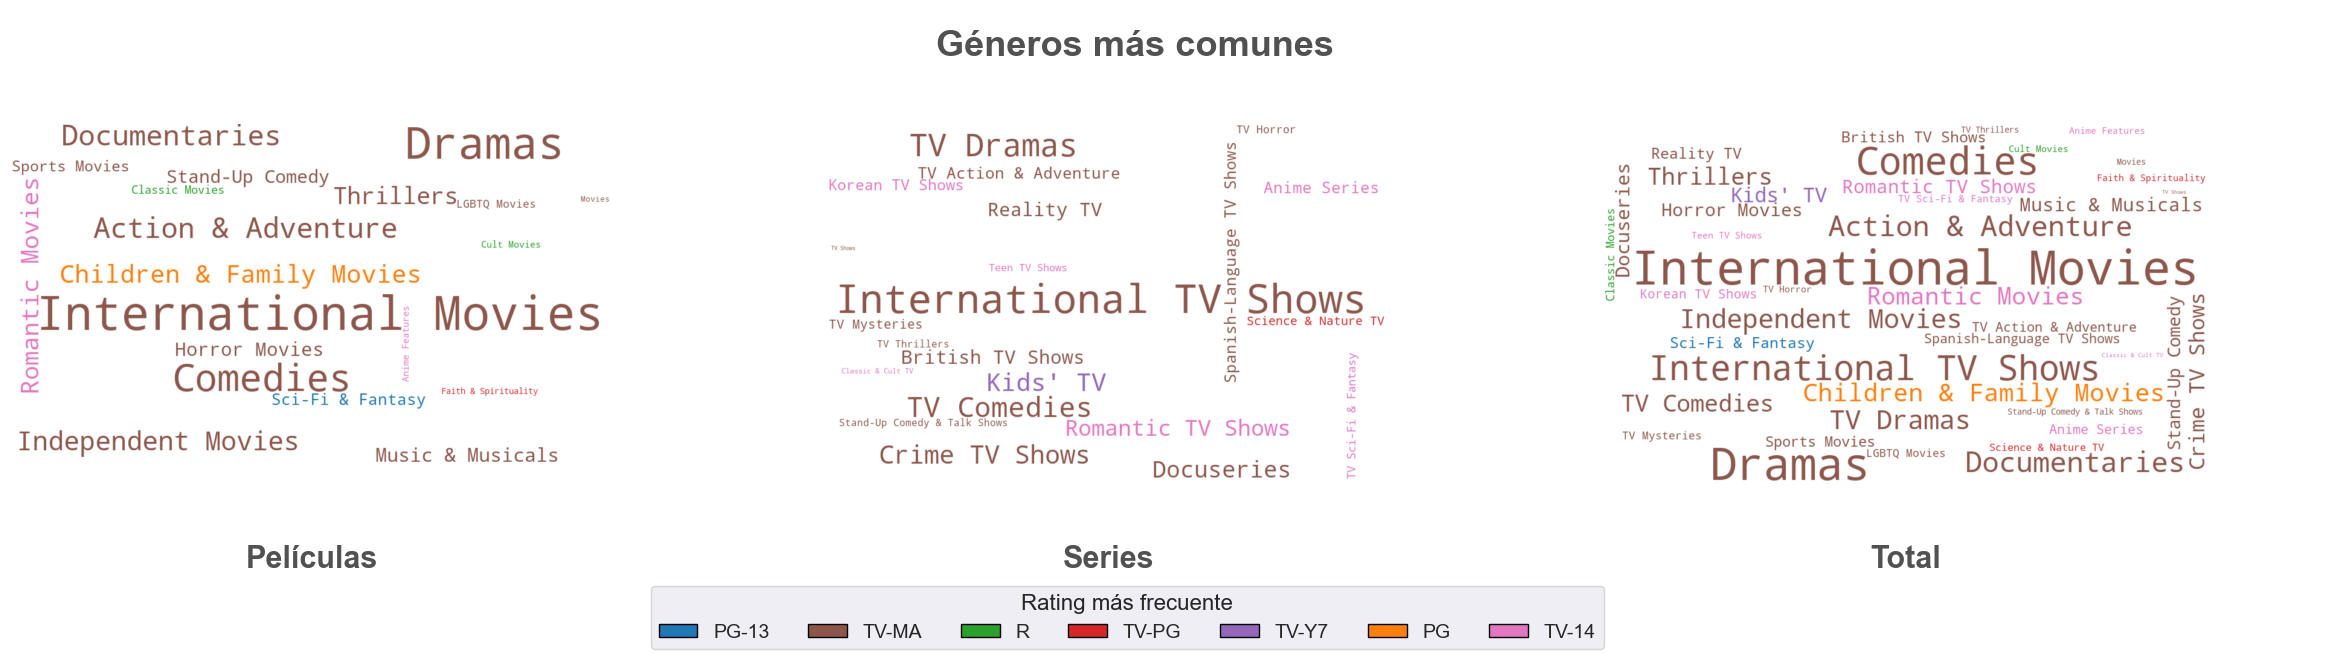

In [677]:
# Wordcloud con géneros y ratings más frecuentes
# Colores
ratings = list(df_genre['rating'].unique())
ratings.extend(list(df_genre_movies['rating'].unique()))
ratings.extend(list(df_genre_shows['rating'].unique()))

ratings = set(ratings)
color_list = ['#1f77b4ff','#8c564bff','#2ca02cff','#d62728ff','#9467bdff','#ff7f0eff','#e377c2ff']

colors_ratings = {}
i = 0
for rating in ratings:
    colors_ratings[rating] = color_list[i]
    i += 1

colors_genres = {}
for genre in df_genre['genre']:
    rating = df_genre.loc[df_genre['genre'] == genre,'rating'].iloc[0]
    colors_genres[genre] = colors_ratings[rating]

# Function to map colors
def map_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return colors_genres.get(word, 'black')  # Return color from the colors dictionary, default to black if not found


# Create a WordCloud object
wordcloud_movies = WordCloud(width=1000, height=600, background_color='white', color_func=map_color).generate_from_frequencies(dict(zip(df_genre_movies['genre'], df_genre_movies['appearances'])))
wordcloud_shows = WordCloud(width=1000, height=600, background_color='white', color_func=map_color).generate_from_frequencies(dict(zip(df_genre_shows['genre'], df_genre_shows['appearances'])))
wordcloud = WordCloud(width=1000, height=600, background_color='white', color_func=map_color).generate_from_frequencies(dict(zip(df_genre['genre'], df_genre['appearances'])))

# Legend element
legend_elements = [ Patch(facecolor=list(colors_ratings.values())[i], edgecolor='black', label=list(colors_ratings.keys())[i]) for i in range(len(colors_ratings)) ]

# Create the figure and axes
fig, (ax1, ax2, ax3, ax6, ax5, ax4) = plt.subplots(1, 6, gridspec_kw={'width_ratios': [10, 1, 10, 1, 10, 1]}, figsize=(30, 10))


# Display the WordClouds
ax1.imshow(wordcloud_movies, interpolation='bilinear')
ax3.imshow(wordcloud_shows, interpolation='bilinear')
ax5.imshow(wordcloud, interpolation='bilinear')


# Create a legend on axes
ax4.legend(handles=legend_elements, bbox_to_anchor=(-19, -0.10), loc='lower center', ncol=len(legend_elements), title='Rating más frecuente', fontsize = 14, title_fontsize = 16)

ax1.set_title('Películas', y = -0.25, fontweight = 'bold', fontsize = 22, alpha = 0.8)
ax3.set_title('Series', y = -0.25, fontweight = 'bold', fontsize = 22, alpha = 0.8)
ax5.set_title('Total', y = -0.25, fontweight = 'bold', fontsize = 22, alpha = 0.8)
fig.suptitle('Géneros más comunes', y = 0.68, fontweight = 'bold', fontsize = 26, alpha = 0.8)
plt.subplots_adjust(top = 0.7)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
ax5.axis('off')
ax6.axis('off')

In [687]:
type(df['duration_int'][0])

numpy.float64

Text(0.5, 0.95, 'Películas - Duración vs género')

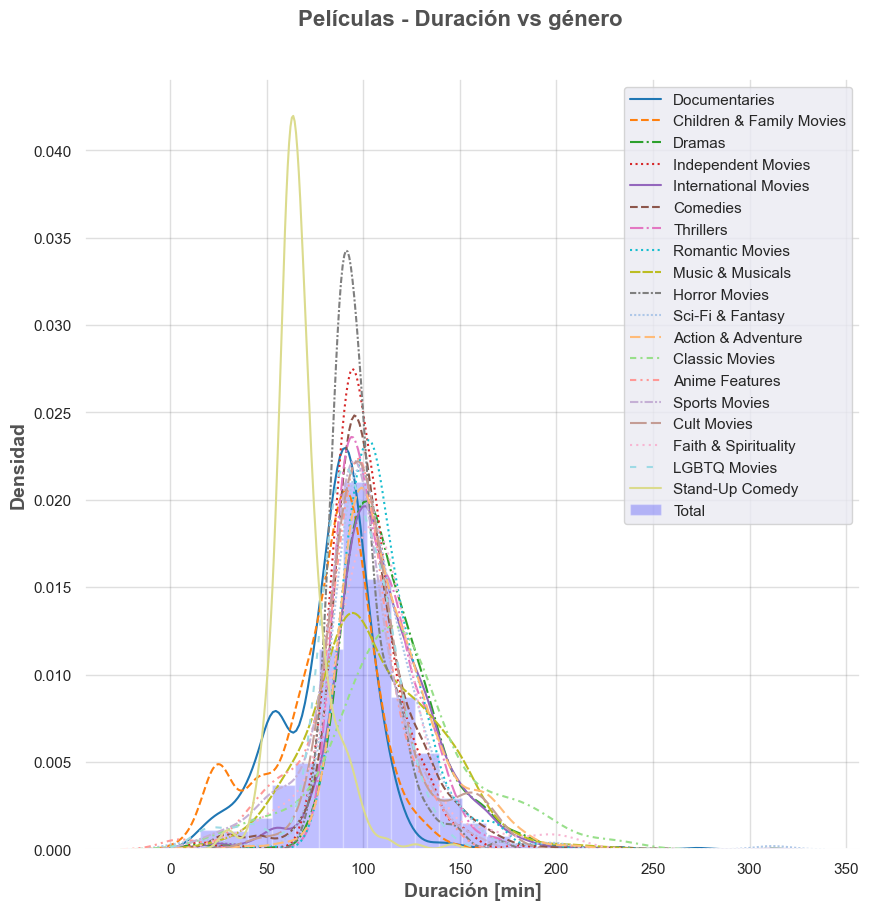

In [688]:
# Histograma y curvas de densidad de duración para cada género
df_movies = list(genres_movies.keys())
df_movies.remove('Movies')

fig,ax = plt.subplots(ncols=1, nrows=1, figsize = (10,10))

# Definición de tipos de línea distintos para cada género
linetypes = ['-', '--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted',
             (0, (5, 1)), (0, (3, 1, 1, 1)), (0, (1, 1)), (0, (5, 2)), (0, (3, 2, 1, 2)),
             (0, (3, 2, 1, 2, 1, 2)), (0, (4, 1, 1, 1)), (0, (8, 2)), (0, (1, 2)), (0, (3, 5)),
             'solid'] 

# Definición de colores distintos para cada género
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                 '#8c564b', '#e377c2', '#17becf', '#bcbd22', '#7f7f7f',
                 '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5',
                 '#c49c94', '#f7b6d2', '#9edae5', '#dbdb8d']

# Ploteo de curva de densidad de duraciones para cada género
i = 0
for genre in df_movies:
    df_genre = df.loc[(df['listed_in'].str.contains(genre)) & (df['type'] == 'Movie')].copy()
    df_genre['duration_int'] = (df_genre.loc[:,'duration_int']).astype(dtype='int', errors = 'ignore')
    sns.kdeplot(df_genre['duration_int'], fill = False, label = genre, lw = 1.5, linestyle = linetypes[i], color = color_palette[i])
    i += 1

# Ploteo histograma de duración para todas las películas
ax.hist(x = df[df['type'] == 'Movie']['duration_int'], bins = 25, alpha = 0.25, color = 'blue', density = True, label = 'Total')

ax.legend()
ax.set_xlabel('Duración [min]', fontsize = 14, fontweight = 'bold', alpha = 0.8)
ax.set_ylabel('Densidad', fontsize = 14, fontweight = 'bold', alpha = 0.8)
ax.set_facecolor('white')
ax.grid(axis = 'both', color = 'grey', alpha = 0.25)
fig.suptitle('Películas - Duración vs género', fontsize = 16, fontweight = 'bold', alpha = 0.8, y = 0.95)

In [689]:
# Dataframes para heatmaps
genres_movies
df_movies = df.loc[df['type'] == 'Movie']
df_shows = df.loc[df['type'] == 'TV Show']

df_hm1 = pd.DataFrame(columns = df_movies.rating.unique(), index = genres_movies.keys())
df_hm2 = pd.DataFrame(columns = df_shows.rating.unique(), index = genres_shows.keys())

for rating in df_hm1.columns:
    df_hm1[rating] = [ df_movies[(df_movies['rating'] == rating) & (df_movies['listed_in'].str.contains(genre))]['show_id'].count() for genre in df_hm1.index]
    

for rating in df_hm2.columns:
    df_hm2[rating] = [ df_shows[(df_shows['rating'] == rating) & (df_shows['listed_in'].str.contains(genre))]['show_id'].count() for genre in df_hm2.index]
    

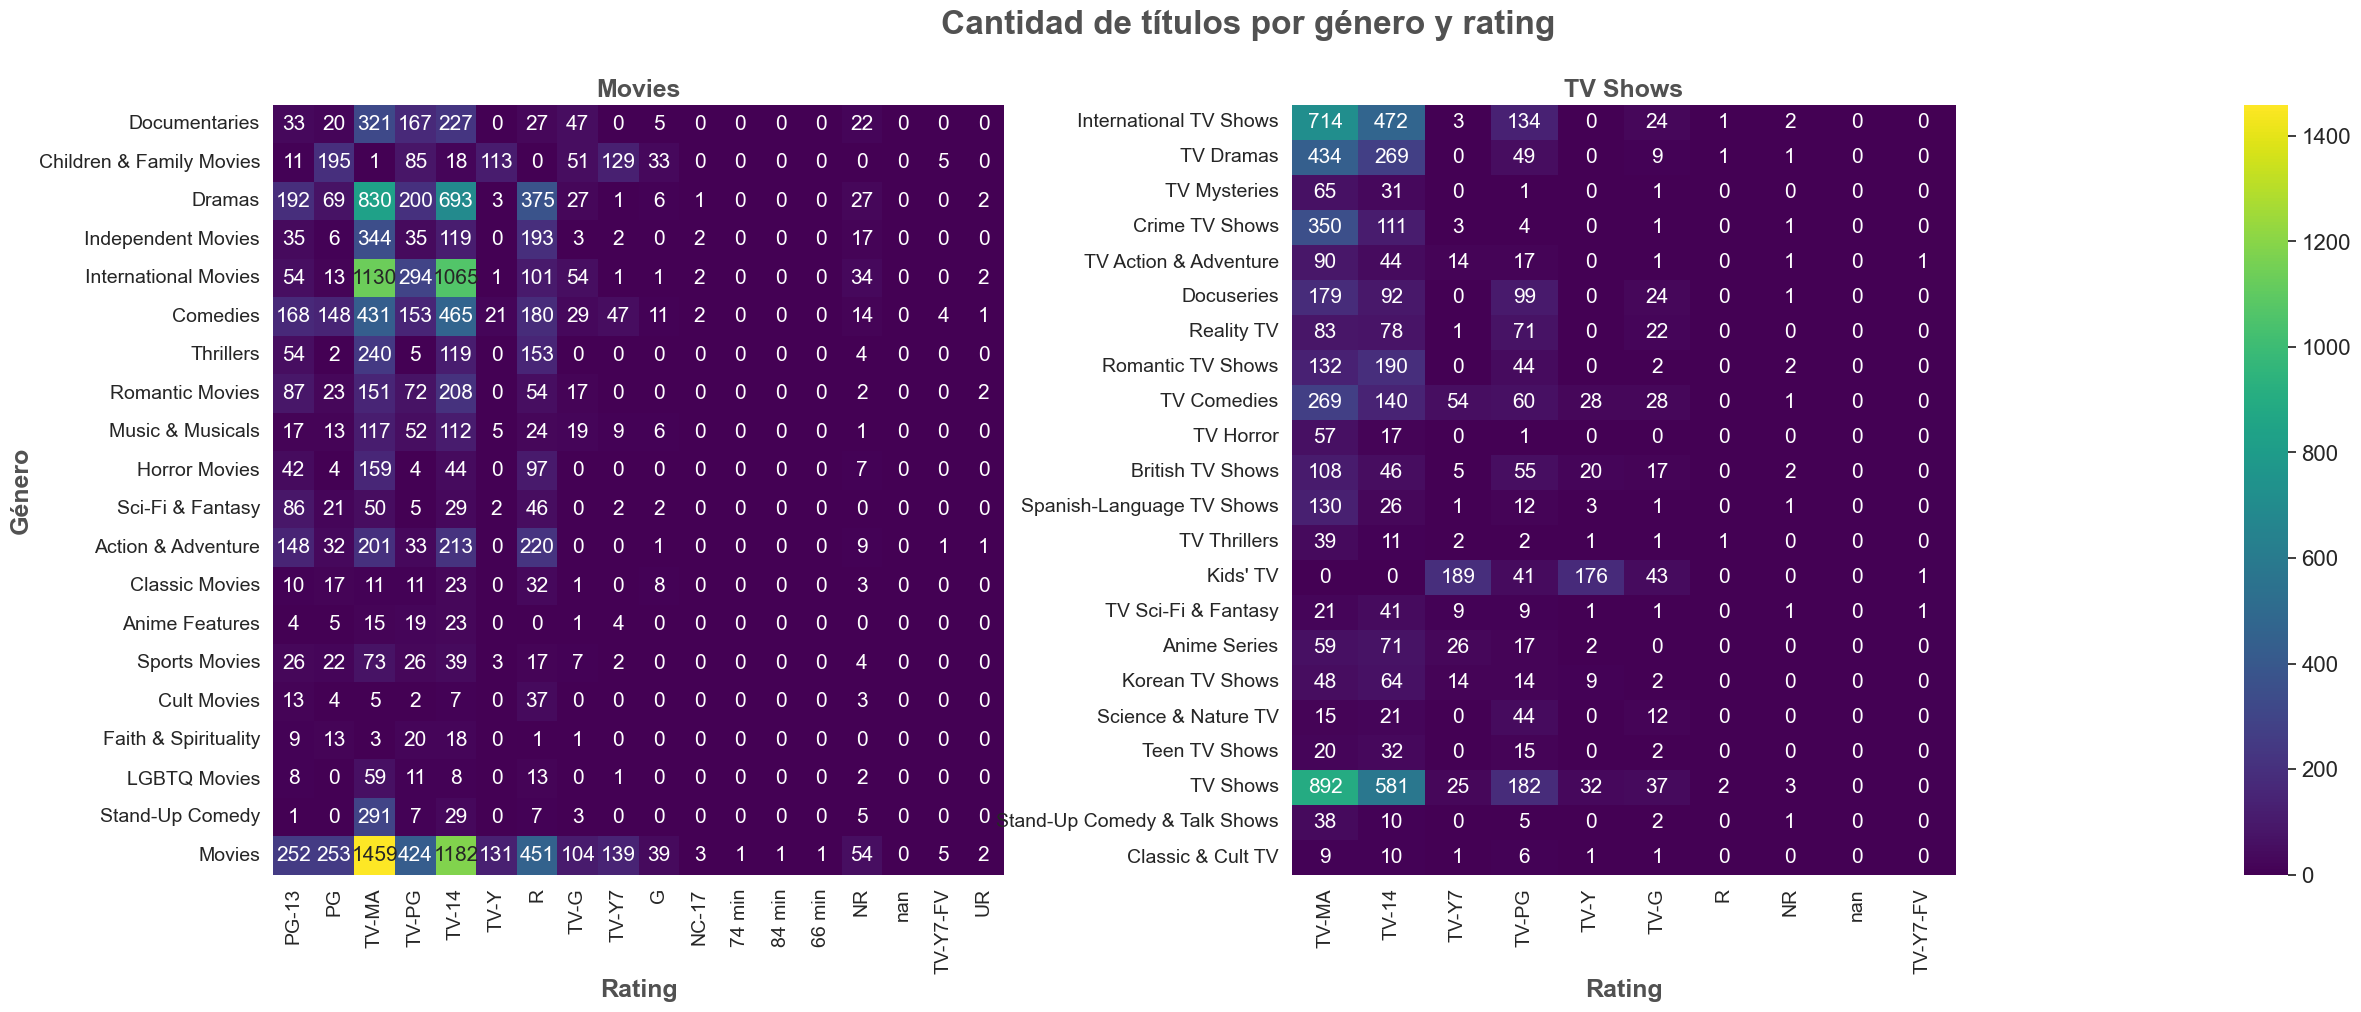

In [690]:
# Heatmaps para géneros y ratings
fig, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, figsize=(26, 10), gridspec_kw={'width_ratios': [1.65, 1.5, 0.1], 'wspace':0.6})

hm1 = sns.heatmap(df_hm1, ax=ax1, annot=True, fmt='d', cmap='viridis', cbar_ax = cbar_ax, vmin = 0, vmax = 1459, annot_kws={"size": 15})

ax1.set_xlabel('Rating', fontsize = 18, fontweight = 'bold', alpha = 0.8)
ax1.set_ylabel('Género', fontsize = 18, fontweight = 'bold', alpha = 0.8)
ax1.tick_params(axis = 'both', labelsize = 14)

ax1.set_title('Movies', fontsize = 18, fontweight = 'bold', alpha = 0.8)

hm2 = sns.heatmap(df_hm2, ax=ax2, annot=True, fmt='d', cmap='viridis', cbar_ax = cbar_ax, vmin = 0, vmax = 1459, annot_kws={"size": 15})

ax2.set_xlabel('Rating', fontsize = 18, fontweight = 'bold', alpha = 0.8)
ax2.set_title('TV Shows', fontsize = 18, fontweight = 'bold', alpha = 0.8)
ax2.tick_params(axis = 'both', labelsize = 14)
ax2.tick_params(axis = 'x', rotation = 90)

fig.suptitle('Cantidad de títulos por género y rating', fontsize = 24, fontweight = 'bold', alpha = 0.8, y = 0.975)

cbar = hm2.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)

Text(0.5, 1.0, 'Cantidad de series publicadas por año')

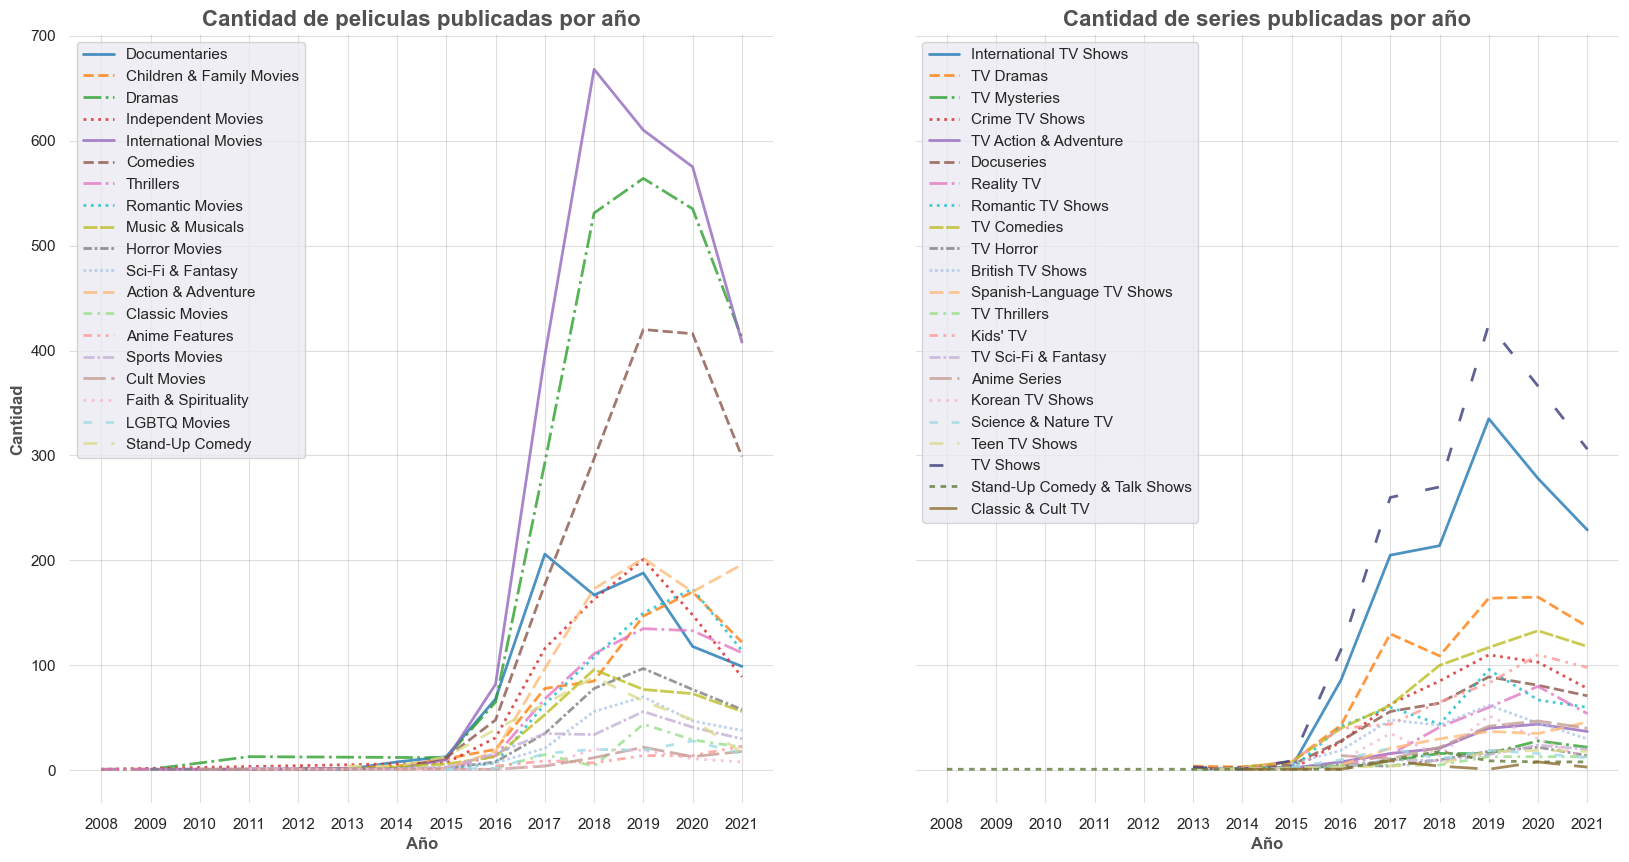

In [691]:
# Cantidad de publicaciones por año para cada género
movies = list(genres_movies.keys())
movies.remove('Movies')
shows = list(genres_shows.keys())


fig,(ax1,ax2) = plt.subplots(ncols=2, nrows=1, figsize = (20,10), sharey = True)

# Definición de tipos de línea distintos para cada género
linestyles = ['-', '--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted',
              (0, (5, 1)), (0, (3, 1, 1, 1)), (0, (1, 1)), (0, (5, 2)), (0, (3, 2, 1, 2)),
              (0, (3, 2, 1, 2, 1, 2)), (0, (4, 1, 1, 1)), (0, (8, 2)), (0, (1, 2)), (0, (3, 5)),
              (0, (5, 5)), (0, (5, 10)), (0, (2, 2)), (0, (10, 5))]

# Definición de colores distintos para cada género
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                 '#8c564b', '#e377c2', '#17becf', '#bcbd22', '#7f7f7f',
                 '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5',
                 '#c49c94', '#f7b6d2', '#9edae5', '#dbdb8d', '#393b79',
                 '#637939', '#8c6d31']

# Ploteo de curvas para películas
i = 0
for genre in movies:
    df_genre = df.loc[(df['listed_in'].str.contains(genre)) & (df['type'] == 'Movie')].copy()
    x = df_genre['year'].value_counts().index
    y = df_genre['year'].value_counts().values
    sns.lineplot(x = x, y = y, label = genre, color = color_palette[i], alpha = 0.8, linewidth = 2, linestyle = linestyles[i], ax = ax1)
    i += 1

# Ploteo de curvas para series
i = 0
for genre in shows:
    df_genre = df.loc[(df['listed_in'].str.contains(genre)) & (df['type'] == 'TV Show')].copy()
    x = df_genre['year'].value_counts().index
    y = df_genre['year'].value_counts().values
    sns.lineplot(x = x, y = y, label = genre, color = color_palette[i], alpha = 0.8, linewidth = 2, linestyle = linestyles[i], ax = ax2)
    i += 1

# Ajuste de graficos
for ax in [ax1,ax2]:
    ax.set_xlabel('Año', fontsize = 12, fontweight = 'bold', alpha = 0.8)
    ax.set_ylabel('Cantidad', fontsize = 12, fontweight = 'bold', alpha = 0.8)
    ax.grid(lw = 0.8)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(100))
    ax.set_facecolor('white')
    ax.grid(axis = 'both', color = 'grey', alpha = 0.25)

ax1.set_title('Cantidad de peliculas publicadas por año', fontsize = 16, fontweight = 'bold', alpha = 0.8)
ax2.set_title('Cantidad de series publicadas por año', fontsize = 16, fontweight = 'bold', alpha = 0.8)

In [692]:
df_movies.query('duration_int > 200')

show_id   type                                              title  \
166     s167  Movie                        Once Upon a Time in America   
717     s718  Movie                        Headspace: Unwind Your Mind   
806     s807  Movie  Seven Souls in the Skull Castle: Season Moon J...   
807     s808  Movie  Seven Souls in the Skull Castle: Season Moon K...   
1019   s1020  Movie                                             Lagaan   
2126   s2127  Movie                               What's Your Raashee?   
2483   s2484  Movie                            Fifty Year Old Teenager   
2484   s2485  Movie                                 Lock Your Girls In   
2487   s2488  Movie                                     No Longer kids   
2488   s2489  Movie                                    Raya and Sakina   
2491   s2492  Movie                             The School of Mischief   
2632   s2633  Movie                       No Direction Home: Bob Dylan   
2731   s2732  Movie                           Kabhi Khushi Kabhie Gham   
3227   s3228  Movie                                       The Irishman   
4253   s4254  Movie                         Black Mirror: Bandersnatch   
4573   s4574  Movie                                       Jodhaa Akbar   
7932   s7933  Movie                                             Sangam   
8327   s8328  Movie                                 The Gospel of Luke   
8404   s8405  Movie      The Lord of the Rings: The Return of the King   

                    director  \
166             Sergio Leone   
717                      NaN   
806           Hidenori Inoue   
807           Hidenori Inoue   
1019      Ashutosh Gowariker   
2126      Ashutosh Gowariker   
2483         Fouad Al Shatti   
2484       Fouad El-Mohandes   
2487         Samir Al Asfory   
2488           Hussein Kamal   
2491  Houssam El-Din Mustafa   
2632         Martin Scorsese   
2731             Karan Johar   
3227         Martin Scorsese   
4253                     NaN   
4573      Ashutosh Gowariker   
7932              Raj Kapoor   
8327             David Batty   
8404           Peter Jackson   

                                                   cast  \
166   Robert De Niro, James Woods, Elizabeth McGover...   
717   Andy Puddicombe, Evelyn Lewis Prieto, Ginger D...   
806   Sota Fukushi, Taichi Saotome, Shohei Miura, Ke...   
807   Mamoru Miyano, Hiroki Suzuki, Tomoki Hirose, R...   
1019  Aamir Khan, Gracy Singh, Rachel Shelley, Paul ...   
2126  Harman Baweja, Priyanka Chopra, Manju Singh, A...   
2483  Abdulhussain Abdulredah, Haifaa Adel, Dawood H...   
2484  Fouad El-Mohandes, Sanaa Younes, Sherihan, Ahm...   
2487  Said Saleh, Hassan Moustafa, Ahmed Zaki, Youne...   
2488  Suhair El-Babili, Shadia, Abdel Moneim Madboul...   
2491  Suhair El-Babili, Adel Emam, Saeed Saleh, Youn...   
2632  Bob Dylan, Joan Baez, Dave Van Ronk, Peter Yar...   
2731  Amitabh Bachchan, Jaya Bhaduri, Shah Rukh Khan...   
3227  Robert De Niro, Al Pacino, Joe Pesci, Harvey K...   
4253  Fionn Whitehead, Will Poulter, Craig Parkinson...   
4573  Hrithik Roshan, Aishwarya Rai Bachchan, Sonu S...   
7932  Raj Kapoor, Vyjayanthimala, Rajendra Kumar, La...   
8327  Selva Rasalingam, Karima Gouit, Mourad Zaoui, ...   
8404  Elijah Wood, Ian McKellen, Liv Tyler, Viggo Mo...   

                                     country date_added  release_year rating  \
166                     Italy, United States 2021-09-01          1984      R   
717                                  Unknown 2021-06-15          2021   TV-G   
806                                  Unknown 2021-06-02          2017  TV-14   
807                                  Unknown 2021-06-02          2017  TV-PG   
1019                   India, United Kingdom 2021-04-17          2001     PG   
2126                                   India 2020-08-15          2009  TV-PG   
2483                                 Unknown 2020-05-21          1996  TV-14   
2484                                 Unknown 2020-05-21       

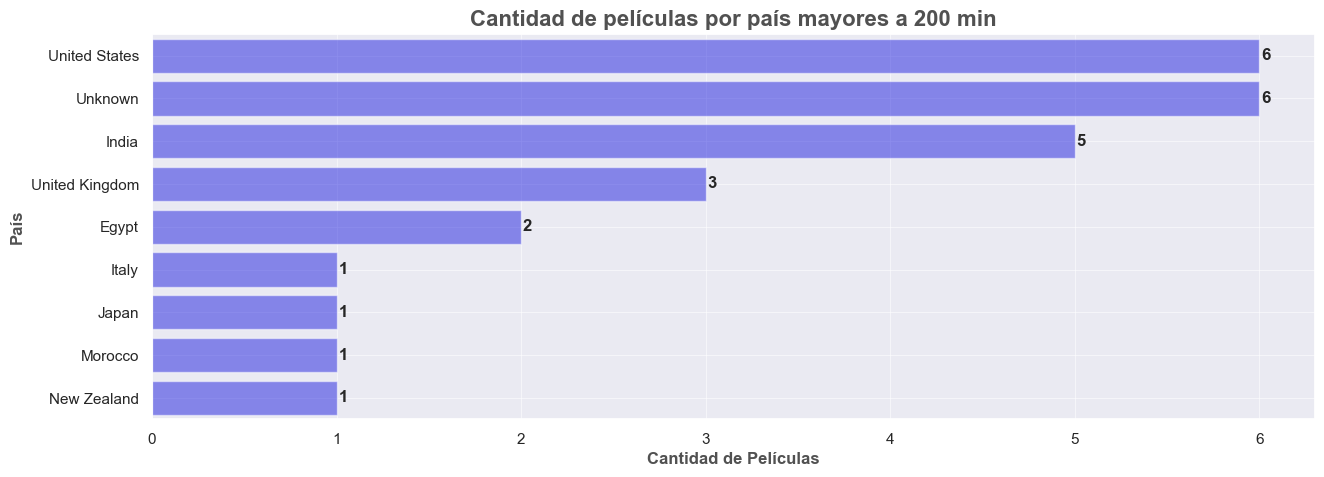

In [693]:
# Países con más películas de duración superior a 200 minutos

# Diccionario con conteos
countries = {}
for country in df_movies.query('duration_int > 200')['country']:
    for i in country.split(','):
        i = i.strip()
        if i not in countries:
            countries[i] =1
        else:
            countries[i] += 1

# Dataframe con conteos (generación y orden)
df_countries = pd.DataFrame(list(countries.items()), columns=['Country', 'Count'])
df_countries = df_countries.sort_values(by='Count', ascending=False).head(15)

# Ploteo
fig,ax = plt.subplots(figsize = (15,5))
sns.barplot(data = df_countries, x = 'Count', y = 'Country', color = 'blue', alpha = 0.5, orient='horizontal')
ax.grid(lw = 0.5)

# Textos
for i in range(len(df_countries)):
    plt.text(y=i+0.1, x=df_countries['Count'].iloc[i] + 0.035, s=str(df_countries['Count'].iloc[i]), ha='center', fontweight = 'bold')

# Ajuste de gráfico
ax.set_xlabel ('Cantidad de Películas', fontsize = 12, fontweight = 'bold', alpha = 0.8)
ax.set_ylabel ('País', fontsize = 12, fontweight = 'bold', alpha = 0.8)
ax.set_title ('Cantidad de películas por país mayores a 200 min', fontsize = 16, fontweight = 'bold', alpha = 0.8)
ax.grid(lw = 0.4)

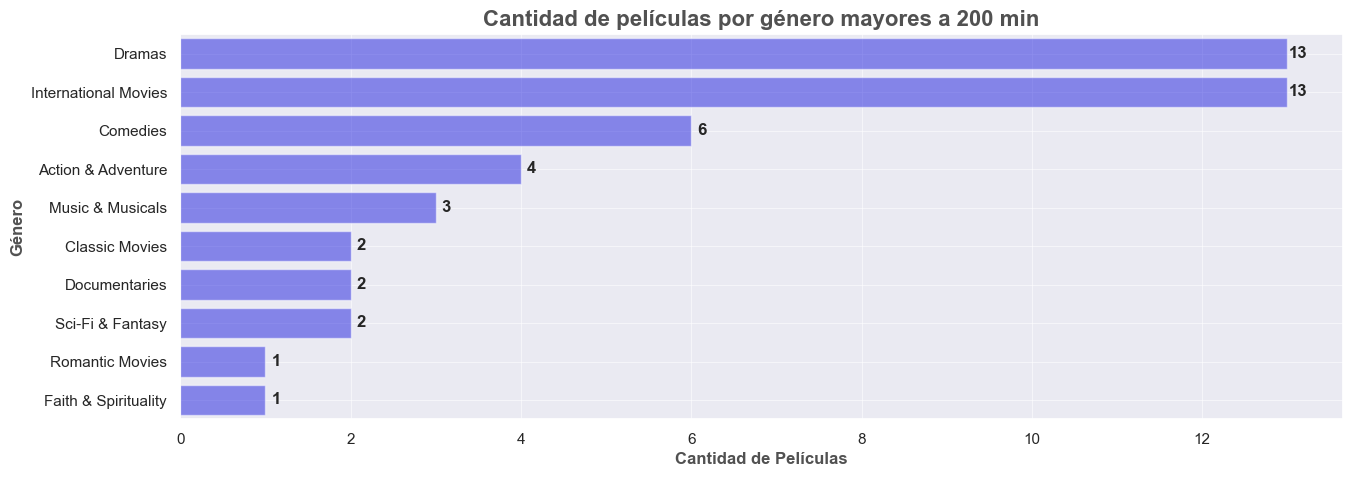

In [694]:
# Géneros con más películas de duración superior a 200 minutos
genres = {}
for genre in df_movies.query('duration_int>200')['listed_in']:
    for subgenre in genre.split(','):
        subgenre = subgenre.strip()
        if subgenre not in genres:
            genres[subgenre] =1
        else:
            genres[subgenre] += 1

# Dataframe con conteos (generación y orden)
df_genres = pd.DataFrame(list(genres.items()), columns=['genre', 'Count'])
df_genres = df_genres.sort_values(by='Count', ascending=False).head(15)

# Ploteo
fig,ax = plt.subplots(figsize = (15,5))
sns.barplot(data = df_genres, x = 'Count', y = 'genre', color = 'blue', alpha = 0.5, orient='horizontal')
ax.grid(lw = 0.5)

# Textos
for i in range(len(df_genres)):
    plt.text(y=i+0.1, x=df_genres['Count'].iloc[i] + 0.125, s=str(df_genres['Count'].iloc[i]), ha='center', fontweight = 'bold')

# Ajuste de gráfico
ax.set_xlabel ('Cantidad de Películas', fontsize = 12, fontweight = 'bold', alpha = 0.8)
ax.set_ylabel ('Género', fontsize = 12, fontweight = 'bold', alpha = 0.8)
ax.set_title ('Cantidad de películas por género mayores a 200 min', fontsize = 16, fontweight = 'bold', alpha = 0.8)
ax.grid(lw = 0.4)

In [695]:
# Cargar el dataset
path = 'netflix_titles.csv'
data = pd.read_csv(path, sep = ',')

# Filtrar solo las películas con categorías de clasificación específicas
filtered_movies = data[(data['type'] == 'Movie') & (data['rating'].isin(['G', 'TV-Y', 'TV-Y7', 'TV-Y7-FV']))]

# Convertir 'release_year' y 'duration' a tipo numérico
filtered_movies['release_year'] = pd.to_numeric(filtered_movies['release_year'], errors='coerce')
filtered_movies['duration'] = pd.to_numeric(filtered_movies['duration'].str.replace(' min', ''), errors='coerce')

# Filtrar filas con valores faltantes en 'release_year' y 'duration'
filtered_movies = filtered_movies.dropna(subset=['release_year', 'duration'])

# Crear el gráfico de dispersión interactivo con plotly
fig = px.scatter(filtered_movies, x='release_year', y='duration', color='rating',
                 hover_name='title', size='duration', title='Relaciones entre Año de Lanzamiento, Duración y Clasificación',
                 color_discrete_sequence=px.colors.sequential.Viridis)
fig.update_xaxes(title='Año de Lanzamiento')
fig.update_yaxes(title='Duración')

# Personalizar el título de la leyenda de colores
fig.update_layout(legend_title_text='Categoría')

fig.show()

C:\Users\diego\AppData\Local\Temp\ipykernel_4336\578570391.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\diego\AppData\Local\Temp\ipykernel_4336\578570391.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [696]:
movies_data = data[(data['type'] == 'Movie') & data['duration'].str.contains('min')]

# Extraer la duración como un número entero
movies_data['duration'] = movies_data['duration'].str.replace(' min', '').astype(float)

# Eliminar filas con valores faltantes en la columna 'duration'
movies_data = movies_data.dropna(subset=['duration'])

# Crear el diagrama de violín interactivo con plotly
fig = px.violin(movies_data, x='rating', y='duration', title='Distribución de Duración de Películas por Clasificación')
fig.update_xaxes(title='Clasificación')
fig.update_yaxes(title='Duración (minutos)')
fig.show()

C:\Users\diego\AppData\Local\Temp\ipykernel_4336\1125588598.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [697]:
# Filtrar solo las películas con categorías de clasificación específicas
filtered_movies = data[(data['type'] == 'Movie') & (data['rating'].isin(['G', 'TV-Y', 'TV-Y7', 'TV-Y7-FV']))]

# Convertir 'release_year' y 'duration' a tipo numérico
filtered_movies['release_year'] = pd.to_numeric(filtered_movies['release_year'], errors='coerce')
filtered_movies['duration'] = pd.to_numeric(filtered_movies['duration'].str.replace(' min', ''), errors='coerce')

# Filtrar filas con valores faltantes en 'release_year' y 'duration'
filtered_movies = filtered_movies.dropna(subset=['release_year', 'duration'])

# Crear el gráfico de dispersión interactivo con plotly
fig = px.scatter(filtered_movies, x='release_year', y='duration', color='rating',
                 hover_name='title', size='duration', title='Relaciones entre Año de Lanzamiento, Duración y Clasificación')
fig.update_xaxes(title='Año de Lanzamiento')
fig.update_yaxes(title='Duración')

# Personalizar el título de la leyenda de colores
fig.update_layout(legend_title_text='Categoría')

fig.show()

C:\Users\diego\AppData\Local\Temp\ipykernel_4336\4234318333.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\diego\AppData\Local\Temp\ipykernel_4336\4234318333.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

